In [71]:
!pip install wget
!pip install PyGithub
!pip install openpyxl
# #!pip install pandas --upgrade

# Import libraries

In [72]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

import tensorflow as tf

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

Set and clear output directories

In [73]:
# remove all existing csv files
! rm *.csv
! rm *.xlsx


if path.exists('/kaggle/working/Raw Data') == True:
  shutil.rmtree("/kaggle/working/Raw Data")

if path.exists('/kaggle/working/Raw Data/Multimodal/ECG/') == False:
  os.mkdir('Raw Data')
  os.mkdir('Raw Data/Multimodal')
  os.mkdir('Raw Data/Multimodal/ECG')
  


if path.exists('/kaggle/working/Raw Data/Single Modal/ECG') == False:
  os.mkdir('Raw Data/Single Modal')
  os.mkdir('Raw Data/Single Modal/ECG')

!pwd
!ls

rm: cannot remove '*.xlsx': No such file or directory
/kaggle/working
'Raw Data'   models


# Retrieve datasets

Read xlsx files and convert to csv and transform into datafram for processing

In [74]:
stimulus_desc_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Stimulus_Description.xlsx')
stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
stimulus_desc = pd.read_csv('Stimulus_Description.csv')

In [75]:
stimulus_desc.head()

,Session ID,Video ID,Target Emotion,Title of Video Clip,Time Duration (secs),Active Link of Video
0,1,1,happy,Best Babies Laughing Video Compilation,39,https://drive.google.com/file/d/1ZWD1zyWkHcBI0...
1,1,2,sad,Barely There,39,https://drive.google.com/file/d/13ysQgSsBwy3d8...
2,1,3,neutral,Denali National Park Alaska,39,https://drive.google.com/file/d/1En_ARj18JlBLP...
3,1,4,surprise,World's Highest Commercially Rafted Waterfall,39,https://drive.google.com/file/d/1kCIHXEklgpWds...
4,1,5,disgust,Disgusting video compilation,39,https://drive.google.com/file/d/1mclmT0EAA-oZ6...


# SREE DEVI: USE THIS LABELS AND WORK FROM HERE TO FIRST TRAIN USING JUST AROUSAL (BINARY FOR STRESS DETECTION)
9 JAN 2025 1010 PM

SAVE OUTPUT FILES AFTER CONFIRMING THE VALUES

In [76]:
self_annotation_multimodal_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx')
self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
self_annotation_multimodal['annotation'] = 'M'
self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)
#self_annotation_multimodal.head()

In [77]:
self_annotation_multimodal.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,Sad,Fear,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_M,13,Female,8,0,0,High,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,Low,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,M
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,M
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,M
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,M


In [78]:
self_annotation_singlemodal_file = pd.read_excel('../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx')
self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
self_annotation_singlemodal['annotation'] = 'S'
self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)
self_annotation_singlemodal.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,Sad,Fear,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_W,21,Female,6,0,0,Moderate,VeryLow,VeryLow,VeryLow,VeryHigh,VeryLow,VeryLow,5,Neutral,HV,LA,HVLA,S
1,1,1,2,M_W,21,Female,2,4,2,VeryLow,High,Low,VeryHigh,VeryLow,Moderate,Moderate,Never watched,Anger,LV,LA,LVLA,S
2,1,1,3,M_W,21,Female,7,6,6,Moderate,Moderate,VeryLow,Low,Moderate,VeryLow,Moderate,Never watched,Mixed,HV,HA,HVHA,S
3,1,1,4,M_W,21,Female,7,3,4,Moderate,Moderate,VeryLow,VeryLow,Low,VeryLow,Low,Never watched,Mixed,HV,LA,HVLA,S
4,1,1,5,M_W,21,Female,0,8,8,VeryLow,VeryLow,VeryLow,High,VeryLow,VeryHigh,High,Never watched,Disgust,LV,HA,LVHA,S


In [79]:
self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
merged_dataframe = pd.concat(self_annotation_frames)
#merged_dataframe.head()
#merged_dataframe.tail()
table_frame = merged_dataframe.copy()

In [80]:
merged_dataframe.head()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,Sad,Fear,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
0,1,1,1,M_M,13,Female,8,0,0,High,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,M
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,Low,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,M
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,M
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,M
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,M


In [81]:
merged_dataframe.tail()

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,Sad,Fear,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four_Label,annotation
149,12,1,3,Ah_D,14,Male,9,0,9,VeryHigh,VeryLow,Low,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,S
150,12,1,4,Ah_D,14,Male,4,7,0,VeryHigh,VeryLow,High,Moderate,VeryLow,VeryLow,VeryLow,Never watched,Happy,LV,HA,LVHA,S
151,12,1,5,Ah_D,14,Male,0,9,0,VeryLow,VeryLow,VeryLow,High,VeryLow,VeryHigh,VeryLow,Never watched,Disgust,LV,HA,LVHA,S
152,12,1,6,Ah_D,14,Male,0,9,0,VeryLow,VeryLow,VeryLow,VeryHigh,VeryLow,VeryLow,VeryLow,Never watched,Anger,LV,HA,LVHA,S
153,12,1,7,Ah_D,14,Male,0,0,0,VeryLow,VeryLow,VeryHigh,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Fear,LV,LA,LVLA,S


In [82]:
merged_dataframe.columns

Index(['Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Gender',
       'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad',
       'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score',
       'Emotion', 'Valence', 'Arousal', 'Four_Label', 'annotation'],
      dtype='object')

In [83]:
cols = []
cols.append('Raw Data')
for col in merged_dataframe.columns:
    cols.append(col)

In [84]:
cols

['Raw Data',
 'Participant Id',
 'Session ID',
 'Video ID',
 'Name',
 'Age',
 'Gender',
 'Valence level',
 'Arousal level',
 'Dominance level',
 'Happy',
 'Sad',
 'Fear',
 'Anger',
 'Neutral',
 'Disgust',
 'Surprised',
 'Familiarity Score',
 'Emotion',
 'Valence',
 'Arousal',
 'Four_Label',
 'annotation']

# Data processing

# Processed data: Collected ECG signals are converted into numerical series data values.

# Use this for further processing - extract features from raw data and use for binary and for four level classification models

In [85]:
arr_shape = 1000
raw_data_arr = []

def form_data(data_array = [], annotation = '', data_path = ''):
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = merged_dataframe.loc[(merged_dataframe['Session ID'] == int(s)) & 
                             (merged_dataframe['Participant Id'] == int(p)) & 
                             (merged_dataframe['Video ID'] == int(v)) &
                             (merged_dataframe['annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return data_array

    
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'M', data_path = "../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Multimodal/ECG/")
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'S', data_path = "../input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Single Modal/ECG/")
cols.append('Target Emotion')
raw_dataframe = pd.DataFrame(raw_data_arr, columns = cols)
raw_dataframe.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
raw_dataframe = raw_dataframe.replace(np.nan, '', regex=True)
raw_dataframe.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,Sad,Fear,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-19.925, -19.934, -19.924, -19.928, -19.922, ...",5,3,6,S_N,13,Male,2,7,2,VeryLow,Moderate,Low,VeryHigh,Low,VeryLow,Low,Never watched,Anger,LV,HA,LVHA,M,anger
1,"[-10.528, -10.521, -10.512, -10.515, -10.529, ...",12,3,3,Q_M,11,Male,4,9,0,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Mixed,LV,HA,LVHA,M,neutral
2,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",5,2,4,S_N,13,Male,6,0,0,High,Low,Low,VeryLow,VeryLow,VeryLow,Low,Never watched,Happy,HV,LA,HVLA,M,surprise
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,3,2,S_N,13,Male,2,6,0,VeryLow,High,High,VeryHigh,Moderate,Low,Moderate,Never watched,Anger,LV,HA,LVHA,M,sad
4,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",7,2,3,A_A,14,Female,0,0,0,VeryLow,VeryLow,VeryLow,VeryLow,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral


# Data visualization

Using Matplotlib, we can visualized the data/signals per emotion into signal waves

In [86]:
plot_frame = raw_dataframe.copy()
plot_frame.head()

,Raw Data,Participant ID,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,Sad,Fear,Anger,Neutral,Disgust,Surprised,Familiarity Score,Emotion,Valence,Arousal,Four label,Modal,Target Emotion
0,"[-19.925, -19.934, -19.924, -19.928, -19.922, ...",5,3,6,S_N,13,Male,2,7,2,VeryLow,Moderate,Low,VeryHigh,Low,VeryLow,Low,Never watched,Anger,LV,HA,LVHA,M,anger
1,"[-10.528, -10.521, -10.512, -10.515, -10.529, ...",12,3,3,Q_M,11,Male,4,9,0,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,VeryLow,Never watched,Mixed,LV,HA,LVHA,M,neutral
2,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",5,2,4,S_N,13,Male,6,0,0,High,Low,Low,VeryLow,VeryLow,VeryLow,Low,Never watched,Happy,HV,LA,HVLA,M,surprise
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,3,2,S_N,13,Male,2,6,0,VeryLow,High,High,VeryHigh,Moderate,Low,Moderate,Never watched,Anger,LV,HA,LVHA,M,sad
4,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",7,2,3,A_A,14,Female,0,0,0,VeryLow,VeryLow,VeryLow,VeryLow,VeryHigh,VeryLow,VeryLow,Never watched,Neutral,LV,LA,LVLA,M,neutral


In [87]:
plot_frame = plot_frame.drop(['Participant ID', 'Session ID', 'Familiarity Score', 'Age', 'Gender', 'Name'], axis = 1)
print("plot_frame printing :")
print(plot_frame)

sad_data = plot_frame.loc[(plot_frame['Emotion'] == 'Sad') & (plot_frame['Target Emotion'] == 'sad')] 
fear_data = plot_frame.loc[(plot_frame['Emotion'] == 'Fear')  & (plot_frame['Target Emotion'] == 'fear')]
happy_data = plot_frame.loc[(plot_frame['Emotion'] == 'Happy') & (plot_frame['Target Emotion'] == 'happy')]
anger_data = plot_frame.loc[(plot_frame['Emotion'] == 'Anger') & (plot_frame['Target Emotion'] == 'anger')]
neutral_data = plot_frame.loc[(plot_frame['Emotion'] == 'Neutral') & (plot_frame['Target Emotion'] == 'neutral')]
mixed_data = plot_frame.loc[(plot_frame['Emotion'] == 'Mixed') & (plot_frame['Target Emotion'] == 'neutral')]
disgust_data = plot_frame.loc[(plot_frame['Emotion'] == 'Disgust') & (plot_frame['Target Emotion'] == 'disgust')]
surprised_data = plot_frame.loc[(plot_frame['Emotion'] == 'Surprise') & (plot_frame['Target Emotion'] == 'surprise')]

plot_frame printing :
                                              Raw Data  Video ID  \
0    [-19.925, -19.934, -19.924, -19.928, -19.922, ...         6   
1    [-10.528, -10.521, -10.512, -10.515, -10.529, ...         3   
2    [-18.561, -18.561, -18.557, -18.557, -18.545, ...         4   
3    [-18.619, -18.624, -18.615, -18.604, -18.616, ...         2   
4    [-18.705, -18.669, -18.642, -18.586, -18.552, ...         3   
..                                                 ...       ...   
394  [-8.5838, -8.5824, -8.5842, -8.5823, -8.5818, ...         6   
395  [-18.702, -18.694, -18.692, -18.678, -18.665, ...         1   
396  [2.8352, 2.8367, 2.8322, 2.8241, 2.8234, 2.829...         1   
397  [6.1257, 6.1156, 6.1136, 6.1148, 6.1061, 6.107...         4   
398  [6.901, 6.8998, 6.9066, 6.9134, 6.9168, 6.9102...         7   

     Valence level  Arousal level  Dominance level    Happy       Sad  \
0                2              7                2  VeryLow  Moderate   
1              

In [88]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        plt.plot(y)
        #x = np.arange(y.size)
        #plt.plot(x, y)
    
    plt.tight_layout()
    plt.title(title)
    plt.show()

**SAD**

<Figure size 576x396 with 0 Axes>

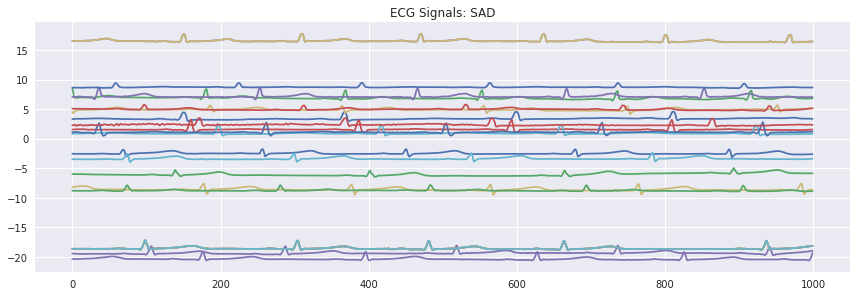

In [89]:
plot_signals(data_arr = sad_data, title = 'ECG Signals: SAD')

**FEAR**

<Figure size 576x396 with 0 Axes>

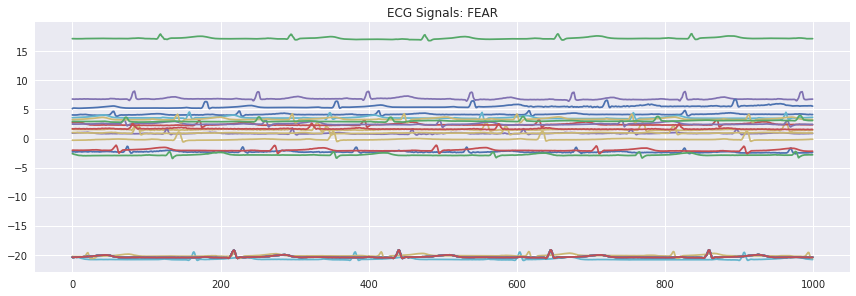

In [90]:
plot_signals(data_arr = fear_data, title = 'ECG Signals: FEAR')

**HAPPY**: Signals scatters on different levels

<Figure size 576x396 with 0 Axes>

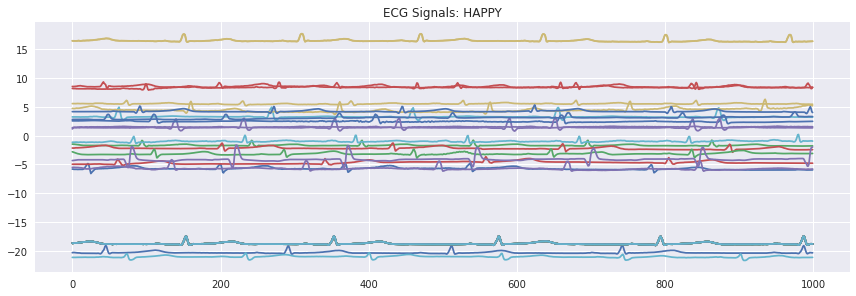

In [91]:
plot_signals(data_arr = happy_data, title = 'ECG Signals: HAPPY')

**ANGER**: Signals scatters on different levels

<Figure size 576x396 with 0 Axes>

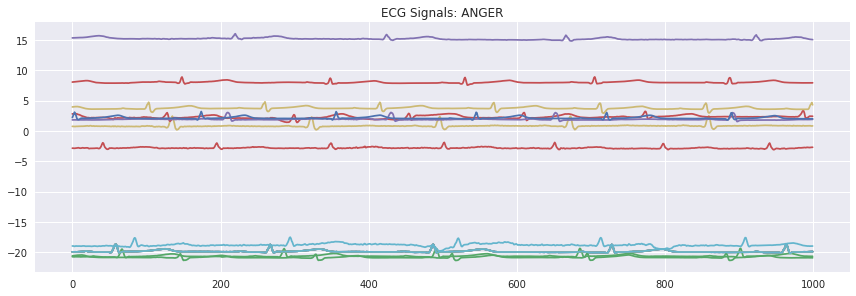

In [92]:
plot_signals(data_arr = anger_data, title = 'ECG Signals: ANGER')

**NEUTRAL**: Signals above 0 region are scatterd. Some are on -15 to -20 area

<Figure size 576x396 with 0 Axes>

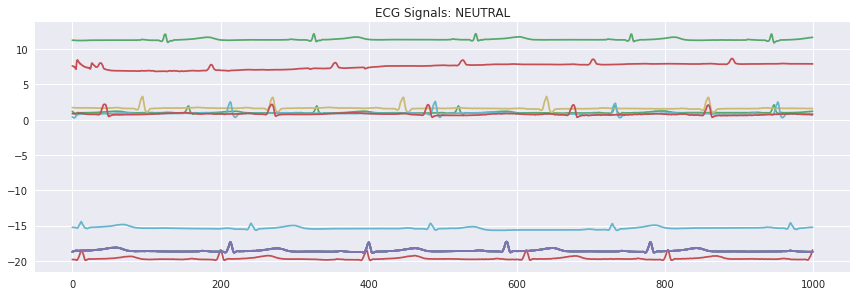

In [93]:
plot_signals(data_arr = neutral_data, title = 'ECG Signals: NEUTRAL')

**MIXED**: Most signals resides on zero level

<Figure size 576x396 with 0 Axes>

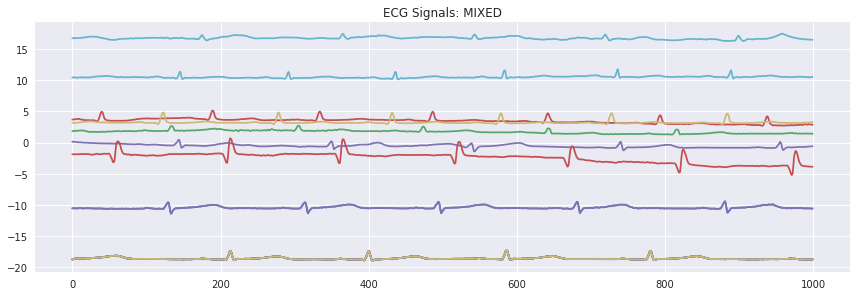

In [94]:
plot_signals(data_arr = mixed_data, title = 'ECG Signals: MIXED')

**DISGUST** : Signals are on 0-5 region and a lot on -20 level

<Figure size 576x396 with 0 Axes>

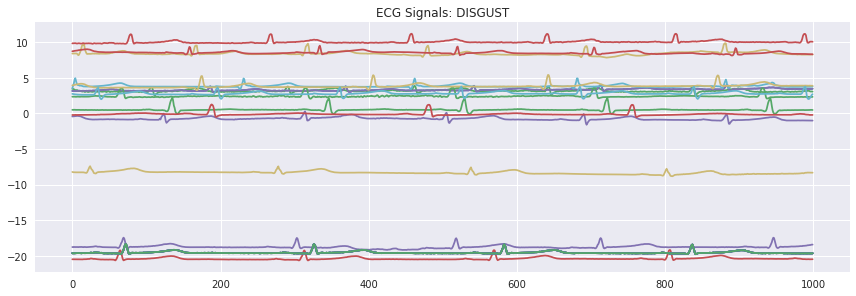

In [95]:
plot_signals(data_arr = disgust_data, title = 'ECG Signals: DISGUST')

**SURPRISED** : signals are all similar and residing near zero region

<Figure size 576x396 with 0 Axes>

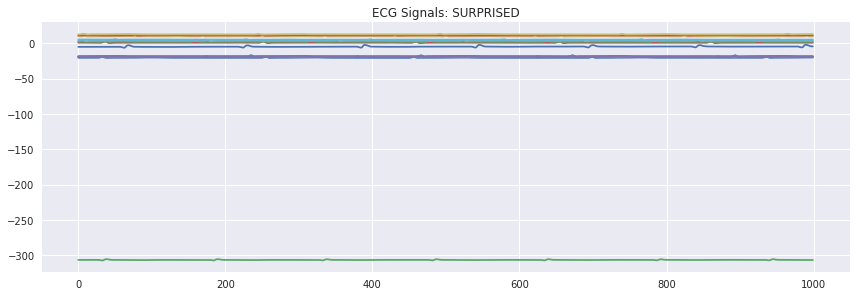

In [96]:
plot_signals(data_arr = surprised_data, title = 'ECG Signals: SURPRISED')

**Findings:** Uncertain on possible recognized pattern based on visual representation of the data

# Model creation and training

In [97]:
# # #train_d_frame = plot_frame.copy().drop(['Video ID', 'Valence level', 'Arousal level',
# # #                                        'Dominance level', 'Happy', 'Sad', 'Fear',
# # #                                        'Anger', 'Neutral', 'Disgust', 'Surprised',
# # #                                        'Valence', 'Arousal', 'Four label', 'Modal'
# # #                                       ], axis = 1)
# train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
#                                         'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
#                                        ], axis = 1)

train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
                                        'Anger', 'Neutral', 'Disgust', 'Surprised', 'Modal'
                                       ], axis = 1)
train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
train_d_frame.head() # check whether arousal and valence and four label are there


,feature,Valence level,Arousal level,Dominance level,emotion,Valence,Arousal,Four label,Target Emotion
0,"[-19.925, -19.934, -19.924, -19.928, -19.922, ...",2,7,2,Anger,LV,HA,LVHA,anger
1,"[-10.528, -10.521, -10.512, -10.515, -10.529, ...",4,9,0,Mixed,LV,HA,LVHA,neutral
2,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",6,0,0,Happy,HV,LA,HVLA,surprise
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",2,6,0,Anger,LV,HA,LVHA,sad
4,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",0,0,0,Neutral,LV,LA,LVLA,neutral


In [98]:
# train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
#                                         'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
#                                        ], axis = 1)
# train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
# #train_d_frame.head()


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation

# # Prepare features and labels
# x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
# y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# # Standardize features
# sc = StandardScaler()
# x = sc.fit_transform(x)

# # Encode labels
# labelencoder = LabelEncoder()
# y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
# y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# # Split data into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# # Define the number of labels
# num_labels = y.shape[1]

# # Build the model
# model = Sequential()

# # Input layer + first hidden layer
# model.add(Dense(8, input_shape=(x_train.shape[1],), activation='relu'))

# # Output layer
# model.add(Dense(num_labels, activation='softmax'))

In [99]:
# model.summary()

In [100]:
# model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [101]:
# # Define training settings
# num_epochs = 10
# num_batch_size = 10

# # Set up ModelCheckpoint
# checkpointer = ModelCheckpoint(filepath='./ecg_emotion_recognizer.hdf5', 
#                                 verbose=1, save_best_only=True)

# # Train the model
# start = datetime.now()
# model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
#           validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)
# duration = datetime.now() - start
# print("Training completed in time: ", duration)



# Model accuracy

In [102]:
# # Evaluate the model
# test_accuracy = model.evaluate(x_test, y_test, verbose=0)
# print("Test Accuracy: ", test_accuracy)


# Initial Findings

**Initial Findings**: Model displayed low accuracy. Need to look for possible improvements. Will try feature extraction on raw data signals.

In [103]:
from __future__ import division
#from matplotlib import pyplot as plt
import scipy.io as spio
#import numpy as np
import statistics
from scipy.stats import kurtosis
from scipy.stats import skew
import sys
#sys.path.append("/home/chandan/python-workspace/")
#import BOCPD as ocpd #import bocpd from another file
import cProfile
from functools import partial

In [104]:

## Reference: https://github.com/chandanacharya1/ECG-Feature-extraction-using-Python/blob/master/features.py
####################### FEATURE DEFINITIONS ###################################


def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = sci_label(np.diff(p) < threshold)
 
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
    #for i in np.unique(peak_groups):    
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

"""TIME DOMAIN"""
#independent function to calculate RMSSD
def calc_rmssd(list):
    diff_nni = np.diff(list)#successive differences
    return np.sqrt(np.mean(diff_nni ** 2))
    
    
 #independent function to calculate AVRR   
def calc_avrr(list):
    return sum(list)/len(list)

 #independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

 #independent function to calculate SKEW   
def calc_skew(list):
    return skew(list)

 #independent function to calculate KURT   
def calc_kurt(list):
    return kurtosis(list)

def calc_NNx(list):
    #diff_nni = np.diff(list)
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
    #return sum(np.abs(diff_nni) > 50)
    return nnxx
    
def calc_pNNx(list):
    #length_int = len(list)
    #diff_nni = np.diff(list)
    #nni_50 = sum(np.abs(diff_nni) > 50)
    #return 100 * nni_50 / length_int
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    pnnxx = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    #return sum(np.abs(diff_nni) > 50)
    return pnnxx
    
"""NON LINEAR DOMAIN"""
 #independent function to calculate SD1
def calc_SD1(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
 #independent function to calculate SD2
def calc_SD2(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                   diff_nn_intervals, ddof=1) ** 2)
    
 #independent function to calculate SD1/SD2
def calc_SD1overSD2(list):
      diff_nn_intervals = np.diff(list)
      sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
      sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                    diff_nn_intervals, ddof=1) ** 2)
      ratio_sd2_sd1 = sd2 / sd1
      return ratio_sd2_sd1
    
    
 #independent function to calculate CSI
def calc_CSI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L/T
       
 #independent function to calculate CVI
def calc_CVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return np.log10(L * T)
 
 #independent function to calculate modified CVI
def calc_modifiedCVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L ** 2 / T


def calc_meanrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.mean(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

    
def calc_hr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    hr = 60000/rr
    return np.mean(hr) 

    

In [105]:
train_d_frame.head()

,feature,Valence level,Arousal level,Dominance level,emotion,Valence,Arousal,Four label,Target Emotion
0,"[-19.925, -19.934, -19.924, -19.928, -19.922, ...",2,7,2,Anger,LV,HA,LVHA,anger
1,"[-10.528, -10.521, -10.512, -10.515, -10.529, ...",4,9,0,Mixed,LV,HA,LVHA,neutral
2,"[-18.561, -18.561, -18.557, -18.557, -18.545, ...",6,0,0,Happy,HV,LA,HVLA,surprise
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",2,6,0,Anger,LV,HA,LVHA,sad
4,"[-18.705, -18.669, -18.642, -18.586, -18.552, ...",0,0,0,Neutral,LV,LA,LVLA,neutral


In [106]:
print("Column names:", train_d_frame.columns)
print("\nFirst few rows:")
print(train_d_frame.head())

Column names: Index(['feature', 'Valence level', 'Arousal level', 'Dominance level',
       'emotion', 'Valence', 'Arousal', 'Four label', 'Target Emotion'],
      dtype='object')

First few rows:
                                             feature  Valence level  \
0  [-19.925, -19.934, -19.924, -19.928, -19.922, ...              2   
1  [-10.528, -10.521, -10.512, -10.515, -10.529, ...              4   
2  [-18.561, -18.561, -18.557, -18.557, -18.545, ...              6   
3  [-18.619, -18.624, -18.615, -18.604, -18.616, ...              2   
4  [-18.705, -18.669, -18.642, -18.586, -18.552, ...              0   

   Arousal level  Dominance level  emotion Valence Arousal Four label  \
0              7                2    Anger      LV      HA       LVHA   
1              9                0    Mixed      LV      HA       LVHA   
2              0                0    Happy      HV      LA       HVLA   
3              6                0    Anger      LV      HA       LVHA   
4          

# Clustering to create 4 clusters and own labels of high/low arousal & valence with Balancing and Cross Validation

In [107]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import ast
from scipy.stats import kurtosis, skew
from scipy.ndimage import label as sci_label
import statistics
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib
import os


## Reference: https://github.com/chandanacharya1/ECG-Feature-extraction-using-Python/blob/master/features.py
####################### FEATURE DEFINITIONS ###################################


def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = sci_label(np.diff(p) < threshold)
 
    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
    #for i in np.unique(peak_groups):    
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

"""TIME DOMAIN"""
#independent function to calculate RMSSD
def calc_rmssd(list):
    diff_nni = np.diff(list)#successive differences
    return np.sqrt(np.mean(diff_nni ** 2))
    
    
 #independent function to calculate AVRR   
def calc_avrr(list):
    return sum(list)/len(list)

 #independent function to calculate SDRR   
def calc_sdrr(list):
    return statistics.stdev(list)

 #independent function to calculate SKEW   
def calc_skew(list):
    return skew(list)

 #independent function to calculate KURT   
def calc_kurt(list):
    return kurtosis(list)

def calc_NNx(list):
    #diff_nni = np.diff(list)
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
    #return sum(np.abs(diff_nni) > 50)
    return nnxx
    
def calc_pNNx(list):
    #length_int = len(list)
    #diff_nni = np.diff(list)
    #nni_50 = sum(np.abs(diff_nni) > 50)
    #return 100 * nni_50 / length_int
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    pnnxx = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    #return sum(np.abs(diff_nni) > 50)
    return pnnxx
    
"""NON LINEAR DOMAIN"""
 #independent function to calculate SD1
def calc_SD1(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
 #independent function to calculate SD2
def calc_SD2(list):
    diff_nn_intervals = np.diff(list)
    return np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                   diff_nn_intervals, ddof=1) ** 2)
    
 #independent function to calculate SD1/SD2
def calc_SD1overSD2(list):
      diff_nn_intervals = np.diff(list)
      sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
      sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                    diff_nn_intervals, ddof=1) ** 2)
      ratio_sd2_sd1 = sd2 / sd1
      return ratio_sd2_sd1
    
    
 #independent function to calculate CSI
def calc_CSI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L/T
       
 #independent function to calculate CVI
def calc_CVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return np.log10(L * T)
 
 #independent function to calculate modified CVI
def calc_modifiedCVI(list):
    diff_nn_intervals = np.diff(list)
    sd1 = np.sqrt(np.std(diff_nn_intervals, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(list, ddof=1) ** 2 - 0.5 * np.std(\
                  diff_nn_intervals, ddof=1) ** 2)
    L=4 * sd1
    T=4 * sd2
    return L ** 2 / T


def calc_meanrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.mean(rr)

def calc_medianrr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    return np.median(rr)

    
def calc_hr(list):
    # detect peaks
    peaks, similarity = detect_peaks(list, threshold=0.3)
    # group peaks so we get a single peak per beat (hopefully)
    grouped_peaks = group_peaks(peaks)
    # RR-intervals are the differences between successive peaks
    rr = np.diff(grouped_peaks)
    hr = 60000/rr
    return np.mean(hr) 

    


def extract_features(input_frame):
    """Extract features using the specified method"""
    extract_frame = input_frame.copy()
    
    # Initialize lists for all features
    medianrr = []
    meanrr = []
    rmssd = []
    sdrr_rmssd = []
    hr = []
    avrr = []
    sdrr = []
    skew_val = []  # Changed from skew_
    kurt = []
    NNx = []
    pNNx = []
    SD1 = []
    SD2 = []
    CSI = []
    CVI = []
    modifiedCVI = []
    SD1overSD2 = []
    
    print("Extracting features...")
    # Extract features for each row
    for index, row in extract_frame.iterrows():
        try:
            # Convert string representation to list if necessary
            feature_data = ast.literal_eval(row['feature']) if isinstance(row['feature'], str) else row['feature']
            
            rmssd.append(calc_rmssd(feature_data))
            avrr.append(calc_avrr(feature_data))
            sdrr.append(calc_sdrr(feature_data))
            skew_val.append(calc_skew(feature_data))  # Changed from skew_
            kurt.append(calc_kurt(feature_data))
            NNx.append(calc_NNx(pd.Series(feature_data)))
            pNNx.append(calc_pNNx(pd.Series(feature_data)))
            SD1.append(calc_SD1(feature_data))
            SD2.append(calc_SD2(feature_data))
            CSI.append(calc_CSI(feature_data))
            CVI.append(calc_CVI(feature_data))
            modifiedCVI.append(calc_modifiedCVI(feature_data))
            SD1overSD2.append(calc_SD1overSD2(feature_data))
            meanrr.append(calc_meanrr(pd.Series(feature_data)))
            medianrr.append(calc_medianrr(pd.Series(feature_data)))
            hr.append(calc_hr(pd.Series(feature_data)))
            sdrrrmssd = calc_sdrr(feature_data) / calc_rmssd(feature_data)
            sdrr_rmssd.append(sdrrrmssd)
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            # Append NaN for this row
            for lst in [meanrr, medianrr, rmssd, sdrr_rmssd, hr, avrr, sdrr, skew_val, 
                       kurt, NNx, pNNx, SD1, SD2, CSI, CVI, modifiedCVI, SD1overSD2]:
                lst.append(np.nan)
    
    # Add features to dataframe
    extract_frame['meanrr'] = meanrr
    extract_frame['medianrr'] = medianrr
    extract_frame['sdrr'] = sdrr
    extract_frame['rmssd'] = rmssd
    extract_frame['sdrr_rmssd'] = sdrr_rmssd
    extract_frame['hr'] = hr
    extract_frame['nnx'] = NNx
    extract_frame['pnnx'] = pNNx
    extract_frame['sd1'] = SD1
    extract_frame['sd2'] = SD2
    extract_frame['avrr'] = avrr
    extract_frame['skew'] = skew_val  # Changed from skew_
    extract_frame['kurt'] = kurt
    extract_frame['csi'] = CSI
    extract_frame['cvi'] = CVI
    extract_frame['modifiedcvi'] = modifiedCVI
    extract_frame['sd1_sd2_ratio'] = SD1overSD2
    
    return extract_frame

def prepare_data_for_clustering(extract_frame):
    """Prepare data for clustering"""
    feature_cols = ['meanrr', 'medianrr', 'sdrr', 'rmssd', 'sdrr_rmssd', 'hr', 
                   'nnx', 'pnnx', 'sd1', 'sd2', 'avrr', 'skew', 'kurt',  # Changed from skew_
                   'csi', 'cvi', 'modifiedcvi', 'sd1_sd2_ratio']
    
    # Remove rows with NaN values
    clean_frame = extract_frame.dropna(subset=feature_cols)
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(clean_frame[feature_cols])
    
    return clean_frame, X_scaled, feature_cols

def perform_clustering_and_labeling(clean_frame, X_scaled):
    """Perform clustering and assign arousal/valence labels based on actual mean values"""
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add cluster assignments to the dataframe
    clean_frame['cluster'] = clusters
    
    # Calculate mean arousal and valence for each cluster using the original values
    cluster_analysis = {}
    for cluster in range(4):
        cluster_data = clean_frame[clean_frame['cluster'] == cluster]
        mean_arousal = cluster_data['Arousal level'].mean()
        mean_valence = cluster_data['Valence level'].mean()
        
        # Store the actual mean values and cluster size
        cluster_analysis[cluster] = {
            'mean_arousal': mean_arousal,
            'mean_valence': mean_valence,
            'size': len(cluster_data)
        }
    
    return clean_frame, cluster_analysis

def get_cluster_emotion_mapping(cluster_analysis):
    """Create emotion mapping based on relative arousal and valence levels"""
    # Calculate median values across all clusters to use as thresholds
    arousal_values = [data['mean_arousal'] for data in cluster_analysis.values()]
    valence_values = [data['mean_valence'] for data in cluster_analysis.values()]
    
    median_arousal = np.median(arousal_values)
    median_valence = np.median(valence_values)
    
    cluster_emotions = {}
    
    for cluster, analysis in cluster_analysis.items():
        # Determine arousal and valence categories based on whether they're above or below median
        arousal = "High Arousal" if analysis['mean_arousal'] > median_arousal else "Low Arousal"
        valence = "High Valence" if analysis['mean_valence'] > median_valence else "Low Valence"
        
        # Map emotional categories
        if arousal == "High Arousal" and valence == "High Valence":
            emotion = "Happy/Excited"
        elif arousal == "High Arousal" and valence == "Low Valence":
            emotion = "Angry/Stressed"
        elif arousal == "Low Arousal" and valence == "High Valence":
            emotion = "Calm/Relaxed"
        else:  # Low Arousal, Low Valence
            emotion = "Sad/Depressed"
            
        cluster_emotions[cluster] = {
            'category': f"Cluster {cluster}",
            'arousal_valence': f"{arousal}, {valence}",
            'emotion_category': emotion,
            'size': analysis['size'],
            'mean_arousal': analysis['mean_arousal'],
            'mean_valence': analysis['mean_valence']
        }
    
    return cluster_emotions

def print_cluster_analysis(cluster_emotions):
    """Print detailed analysis of each cluster with actual mean values"""
    print("\n" + "="*80)
    print("DETAILED CLUSTER ANALYSIS")
    print("="*80)
    
    for cluster, details in cluster_emotions.items():
        print(f"\nCLUSTER {cluster}:")
        print("-" * 50)
        print(f"Emotional Category: {details['emotion_category']}")
        print(f"Arousal/Valence: {details['arousal_valence']}")
        print(f"Cluster Size: {details['size']} samples")
        print(f"Mean Arousal Value: {details['mean_arousal']:.2f}")
        print(f"Mean Valence Value: {details['mean_valence']:.2f}")
    
    print("\n" + "="*80)


# def train_models(clean_frame, feature_cols, cluster_emotions):
#     """Train models for emotion category prediction and return the best model"""
#     X = clean_frame[feature_cols]
#     y = clean_frame['emotion_category']
    
#     # Create mapping of emotion categories
#     emotion_mapping = {
#         cluster: details['emotion_category'] 
#         for cluster, details in cluster_emotions.items()
#     }
    
#     print("\nEmotion Categories Mapping:")
#     for cluster, emotion in emotion_mapping.items():
#         print(f"Cluster {cluster}: {emotion}")
    
#     results = {}
#     best_model = None
#     best_accuracy = 0
#     best_model_name = None
    
#     # Split data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     # Scale features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Save the scaler for later use
#     joblib.dump(scaler, 'emotion_scaler.joblib')
    
#     # Train models
#     models = {
#         'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'),
#         'Random Forest': RandomForestClassifier(random_state=42),
#         'Gradient Boosting': GradientBoostingClassifier(random_state=42),
#         'KNN': KNeighborsClassifier(n_neighbors=5)
#     }
    
#     for name, model in models.items():
#         print(f"\n{'-'*50}")
#         print(f"\nTraining {name}...")
        
#         model.fit(X_train_scaled, y_train)
#         y_pred = model.predict(X_test_scaled)
        
#         # Calculate accuracy
#         accuracy = accuracy_score(y_test, y_pred) * 100
        
#         # Get classification report
#         report = classification_report(y_test, y_pred)
        
#         print(f"\n{name} Results:")
#         print(f"Overall Accuracy: {accuracy:.2f}%")
#         print("\nDetailed Performance by Emotion Category:")
#         print(report)
        
#         results[name] = {
#             'model': model,
#             'accuracy': accuracy,
#             'report': report
#         }
        
#         # Update best model if current model has better accuracy
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_model = model
#             best_model_name = name
    
#     # Print best model summary
#     print(f"\n{'='*50}")
#     print(f"Best Model: {best_model_name}")
#     print(f"Accuracy: {best_accuracy:.2f}%")
#     print(f"{'='*50}")
    
#     # Save the best model
#     save_best_model(best_model, best_model_name, feature_cols)
    
#     return results, best_model_name, feature_cols

def train_models_with_cv(clean_frame, feature_cols, cluster_emotions):
    """Train models using k-fold cross validation and enhanced balancing techniques"""
    X = clean_frame[feature_cols]
    y = clean_frame['emotion_category']
    
    # Print initial class distribution
    print("\nInitial class distribution:")
    print(y.value_counts())
    
    # Calculate sampling strategy to balance classes exactly to the majority class size
    max_samples = y.value_counts().max()
    strategy = {emotion: max_samples for emotion in y.value_counts().index}
    
    print("\nTarget samples per class after balancing:")
    print(strategy)
    
    # Initialize SMOTE with the calculated sampling strategy
    smote = SMOTE(random_state=42, sampling_strategy=strategy)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'SVM': SVC(random_state=42, probability=True, class_weight='balanced')
    }
    
    results = {}
    best_model = None
    best_accuracy = 0
    best_model_name = None
    
    # Initialize k-fold cross validation with stratification
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    
    print("\nPerforming cross-validated training with balanced datasets...")
    
    for name, model in models.items():
        print(f"\n{'-'*50}")
        print(f"\nTraining {name}...")
        
        # Create pipeline with scaling and SMOTE
        pipeline = Pipeline([
            ('scaler', scaler),
            ('smote', smote),
            ('classifier', model)
        ])
        
        # Initialize lists to store detailed metrics
        fold_accuracies = []
        fold_reports = []
        
        # Perform cross-validation with simplified output
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Fit pipeline
            pipeline.fit(X_train, y_train)
            
            # Get predictions
            y_pred = pipeline.predict(X_val)
            
            # Calculate accuracy
            accuracy = accuracy_score(y_val, y_pred)
            fold_accuracies.append(accuracy)
            
            # Store classification report
            fold_reports.append(classification_report(y_val, y_pred, output_dict=True))
            
            print(f"Fold {fold} Accuracy: {accuracy:.2f}")
        
        # Calculate and print cross-validation results
        mean_cv_score = np.mean(fold_accuracies) * 100
        std_cv_score = np.std(fold_accuracies) * 100
        
        print(f"\n{name} Cross-Validation Results:")
        print(f"Mean Accuracy: {mean_cv_score:.2f}% (+/- {2*std_cv_score:.2f}%)")
        
        # Fit the pipeline on the full dataset for final evaluation
        pipeline.fit(X, y)
        
        # Get predictions on full dataset
        y_pred = pipeline.predict(X)
        
        # Calculate overall accuracy
        accuracy = accuracy_score(y, y_pred) * 100
        
        # Get classification report
        report = classification_report(y_pred, y)
        
        print("\nFinal Model Performance:")
        print(f"Overall Accuracy: {accuracy:.2f}%")
        print("\nDetailed Performance by Emotion Category:")
        print(report)
        
        # Store results
        results[name] = {
            'pipeline': pipeline,
            'cv_accuracy': mean_cv_score,
            'cv_std': std_cv_score,
            'final_accuracy': accuracy,
            'report': report,
            'fold_reports': fold_reports
        }
        
        # Update best model if current model has better cross-validation score
        if mean_cv_score > best_accuracy:
            best_accuracy = mean_cv_score
            best_model = pipeline
            best_model_name = name
    
    # Print best model summary
    print(f"\n{'='*50}")
    print(f"Best Model: {best_model_name}")
    print(f"Cross-Validation Accuracy: {best_accuracy:.2f}% (+/- {2*results[best_model_name]['cv_std']:.2f}%)")
    print(f"{'='*50}")
    
    # Save the best model
    save_best_model(best_model, best_model_name, feature_cols)
    
    return results, best_model_name, feature_cols

def save_best_model(pipeline, model_name, feature_cols):
    """Save the best model pipeline and its metadata"""
    # Create models directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Save the pipeline
    joblib.dump(pipeline, f'models/best_emotion_model_balanced.joblib')
    
    # Save feature columns for later reference
    with open('models/feature_columns_balanced.txt', 'w') as f:
        f.write('\n'.join(feature_cols))
    
    # Save model metadata
    metadata = {
        'model_name': model_name,
        'feature_columns': feature_cols,
        'date_created': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    pd.Series(metadata).to_json('models/model_metadata_balanced.json')
    
    print(f"\nModel saved successfully:")
    print(f"- Model file: models/ecg_4class_best_emotion_model_balanced.joblib")
    print(f"- Feature columns: models/ecg_4class_feature_columns_balanced.txt")
    print(f"- Metadata: models/ecg_4class_model_metadata_balanced.json")

def main(input_frame):
    # Extract features
    print("Extracting features...")
    extract_frame = extract_features(input_frame)
    
    # Prepare data for clustering
    print("\nPreparing data for clustering...")
    clean_frame, X_scaled, feature_cols = prepare_data_for_clustering(extract_frame)
    
    # Perform clustering and labeling
    print("\nPerforming clustering and assigning labels...")
    labeled_frame, cluster_analysis = perform_clustering_and_labeling(clean_frame, X_scaled)

    # Get and print detailed cluster analysis
    cluster_emotions = get_cluster_emotion_mapping(cluster_analysis)
    print_cluster_analysis(cluster_emotions)
    
    # Add emotion categories to the labeled frame
    labeled_frame['emotion_category'] = labeled_frame['cluster'].map(
        {k: v['emotion_category'] for k, v in cluster_emotions.items()}
    )

    # Add arousal/valence categories
    labeled_frame['arousal_valence_category'] = labeled_frame['cluster'].map(
        {k: v['arousal_valence'] for k, v in cluster_emotions.items()}
    )

       # Create final display dataframe
    display_cols = [
        # Original emotion and self-reported levels
        'emotion', 'Valence level', 'Arousal level',
        
        # Clustering results
        'cluster', 'emotion_category', 'arousal_valence_category',
        
        # ECG features
        'meanrr', 'medianrr', 'sdrr', 'rmssd', 'sdrr_rmssd', 'hr',
        'nnx', 'pnnx', 'sd1', 'sd2', 'avrr', 'skew', 'kurt',
        'csi', 'cvi', 'modifiedcvi', 'sd1_sd2_ratio'
    ]
    
    # Create the final dataframe with selected columns
    final_df = labeled_frame[display_cols].copy()
    
    # Round numerical columns to 3 decimal places
    numerical_cols = final_df.select_dtypes(include=['float64', 'int64']).columns
    final_df[numerical_cols] = final_df[numerical_cols].round(3)
    
    # Reorder columns to group related information
    column_groups = {
        'Original Data': ['emotion', 'Valence level', 'Arousal level'],
        'Clustering Results': ['cluster', 'emotion_category', 'arousal_valence_category'],
        'Time Domain Features': ['meanrr', 'medianrr', 'sdrr', 'rmssd', 'sdrr_rmssd', 'hr', 'nnx', 'pnnx', 'avrr'],
        'Non-Linear Features': ['sd1', 'sd2', 'sd1_sd2_ratio', 'csi', 'cvi', 'modifiedcvi'],
        'Statistical Features': ['skew', 'kurt']
    }
    
    # Add column group headers using pandas MultiIndex
    column_tuples = []
    for group, cols in column_groups.items():
        for col in cols:
            column_tuples.append((group, col))
    
    final_df.columns = pd.MultiIndex.from_tuples(column_tuples)
    
    # Display settings for better readability in Jupyter
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_rows', 20)  # Adjust as needed 
    
    # Print simplified cluster analysis
    print("\nCluster Analysis:")
    for cluster, details in cluster_emotions.items():
        print(f"\nCluster {cluster}: {details['emotion_category']}")
        print(f"Size: {details['size']} samples")
        print(f"Mean Arousal: {details['mean_arousal']:.2f}")
        print(f"Mean Valence: {details['mean_valence']:.2f}")
    

    # Train models with cross-validation and balanced datasets
    print("\nTraining models with cross-validation and balanced datasets...")
    results, best_model_name, feature_cols = train_models_with_cv(labeled_frame, feature_cols, cluster_emotions)
    
    return labeled_frame, cluster_emotions, results, best_model_name
    return labeled_frame, cluster_emotions, results, final_df, best_model_name

# Run the analysis
try:
    labeled_data, cluster_emotions, model_results,final_display_df, best_model_name  = main(train_d_frame)
    
    # Save the labeled data
    labeled_data.to_csv('ecg_4class_features_with_clusters_balanced.csv', index=False)
    
    display(final_display_df)
    
    # Save to CSV if needed
    final_display_df.to_csv('ecg_4class_analysis_results_balanced.csv')
    
    # Create and display cluster summary
    cluster_summary = pd.DataFrame.from_dict(cluster_emotions, orient='index')
    print("\nCluster Summary DataFrame:")
    print(cluster_summary[['emotion_category', 'arousal_valence', 'size']])
    print(f"\nBest performing model was: {best_model_name}")
    print("Model and associated files have been saved to the 'models' directory")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")

Extracting features...
Extracting features...

Preparing data for clustering...

Performing clustering and assigning labels...

DETAILED CLUSTER ANALYSIS

CLUSTER 0:
--------------------------------------------------
Emotional Category: Happy/Excited
Arousal/Valence: High Arousal, High Valence
Cluster Size: 103 samples
Mean Arousal Value: 4.40
Mean Valence Value: 4.57

CLUSTER 1:
--------------------------------------------------
Emotional Category: Angry/Stressed
Arousal/Valence: High Arousal, Low Valence
Cluster Size: 251 samples
Mean Arousal Value: 3.53
Mean Valence Value: 3.96

CLUSTER 2:
--------------------------------------------------
Emotional Category: Calm/Relaxed
Arousal/Valence: Low Arousal, High Valence
Cluster Size: 34 samples
Mean Arousal Value: 3.09
Mean Valence Value: 5.15

CLUSTER 3:
--------------------------------------------------
Emotional Category: Sad/Depressed
Arousal/Valence: Low Arousal, Low Valence
Cluster Size: 11 samples
Mean Arousal Value: 3.18
Mean Vale

/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 2 Accuracy: 1.00
Fold 3 Accuracy: 0.96


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 4 Accuracy: 1.00
Fold 5 Accuracy: 0.97

Logistic Regression Cross-Validation Results:
Mean Accuracy: 97.74% (+/- 4.00%)


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util


Final Model Performance:
Overall Accuracy: 99.25%

Detailed Performance by Emotion Category:
                precision    recall  f1-score   support

Angry/Stressed       0.99      1.00      0.99       248
  Calm/Relaxed       1.00      0.92      0.96        37
 Happy/Excited       1.00      1.00      1.00       103
 Sad/Depressed       1.00      1.00      1.00        11

      accuracy                           0.99       399
     macro avg       1.00      0.98      0.99       399
  weighted avg       0.99      0.99      0.99       399


--------------------------------------------------

Training Random Forest...


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 1 Accuracy: 0.95


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 2 Accuracy: 0.96


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 3 Accuracy: 0.96


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 4 Accuracy: 0.95


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 5 Accuracy: 0.96

Random Forest Cross-Validation Results:
Mean Accuracy: 95.74% (+/- 1.21%)

Final Model Performance:
Overall Accuracy: 100.00%

Detailed Performance by Emotion Category:
                precision    recall  f1-score   support

Angry/Stressed       1.00      1.00      1.00       251
  Calm/Relaxed       1.00      1.00      1.00        34
 Happy/Excited       1.00      1.00      1.00       103
 Sad/Depressed       1.00      1.00      1.00        11

      accuracy                           1.00       399
     macro avg       1.00      1.00      1.00       399
  weighted avg       1.00      1.00      1.00       399


--------------------------------------------------

Training Gradient Boosting...


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 1 Accuracy: 0.95


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 2 Accuracy: 0.95


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 3 Accuracy: 0.97


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 4 Accuracy: 0.96


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 5 Accuracy: 0.96

Gradient Boosting Cross-Validation Results:
Mean Accuracy: 95.99% (+/- 1.87%)

Final Model Performance:
Overall Accuracy: 100.00%

Detailed Performance by Emotion Category:
                precision    recall  f1-score   support

Angry/Stressed       1.00      1.00      1.00       251
  Calm/Relaxed       1.00      1.00      1.00        34
 Happy/Excited       1.00      1.00      1.00       103
 Sad/Depressed       1.00      1.00      1.00        11

      accuracy                           1.00       399
     macro avg       1.00      1.00      1.00       399
  weighted avg       1.00      1.00      1.00       399


--------------------------------------------------

Training KNN...
Fold 1 Accuracy: 0.96
Fold 2 Accuracy: 0.96
Fold 3 Accuracy: 0.90
Fold 4 Accuracy: 0.96


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 200)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 5 Accuracy: 0.96

KNN Cross-Validation Results:
Mean Accuracy: 94.99% (+/- 4.99%)

Final Model Performance:
Overall Accuracy: 97.24%

Detailed Performance by Emotion Category:
                precision    recall  f1-score   support

Angry/Stressed       0.96      1.00      0.98       242
  Calm/Relaxed       1.00      0.87      0.93        39
 Happy/Excited       0.98      0.94      0.96       107
 Sad/Depressed       1.00      1.00      1.00        11

      accuracy                           0.97       399
     macro avg       0.99      0.95      0.97       399
  weighted avg       0.97      0.97      0.97       399


--------------------------------------------------

Training SVM...
Fold 1 Accuracy: 0.93
Fold 2 Accuracy: 0.99


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 3 Accuracy: 0.91
Fold 4 Accuracy: 0.99


/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Angry/Stressed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Happy/Excited will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (251) in class Calm/Relaxed will be larger than the number of samples in the majority class (class #Angry/Stressed -> 201)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/util

Fold 5 Accuracy: 0.96

SVM Cross-Validation Results:
Mean Accuracy: 95.49% (+/- 6.24%)

Final Model Performance:
Overall Accuracy: 95.99%

Detailed Performance by Emotion Category:
                precision    recall  f1-score   support

Angry/Stressed       0.94      1.00      0.97       237
  Calm/Relaxed       1.00      0.83      0.91        41
 Happy/Excited       0.98      0.92      0.95       110
 Sad/Depressed       1.00      1.00      1.00        11

      accuracy                           0.96       399
     macro avg       0.98      0.94      0.96       399
  weighted avg       0.96      0.96      0.96       399


Best Model: Logistic Regression
Cross-Validation Accuracy: 97.74% (+/- 4.00%)

Model saved successfully:
- Model file: models/ecg_4class_best_emotion_model_balanced.joblib
- Feature columns: models/ecg_4class_feature_columns_balanced.txt
- Metadata: models/ecg_4class_model_metadata_balanced.json
An error occurred: not enough values to unpack (expected 5, got 4)


# Ignore code below - used in first iteration by relying on the self-reported ratings to group

# Binary Classifiers (Without balancing)

In [108]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import ast

def extract_features(input_frame):
    """Extract features using the specified method"""
    extract_frame = input_frame.copy()
    
    # Initialize lists for all features
    medianrr = []
    meanrr = []
    rmssd = []
    sdrr_rmssd = []
    hr = []
    avrr = []
    sdrr = []
    skew_ = []
    kurt = []
    NNx = []
    pNNx = []
    SD1 = []
    SD2 = []
    CSI = []
    CVI = []
    modifiedCVI = []
    SD1overSD2 = []
    
    print("Extracting features...")
    # Extract features for each row
    for index, row in extract_frame.iterrows():
        try:
            # Convert string representation to list if necessary
            feature_data = ast.literal_eval(row['feature']) if isinstance(row['feature'], str) else row['feature']
            
            rmssd.append(calc_rmssd(feature_data))
            avrr.append(calc_avrr(feature_data))
            sdrr.append(calc_sdrr(feature_data))
            skew_.append(calc_skew(feature_data))
            kurt.append(calc_kurt(feature_data))
            NNx.append(calc_NNx(pd.Series(feature_data)))
            pNNx.append(calc_pNNx(pd.Series(feature_data)))
            SD1.append(calc_SD1(feature_data))
            SD2.append(calc_SD2(feature_data))
            CSI.append(calc_CSI(feature_data))
            CVI.append(calc_CVI(feature_data))
            modifiedCVI.append(calc_modifiedCVI(feature_data))
            SD1overSD2.append(calc_SD1overSD2(feature_data))
            meanrr.append(calc_meanrr(pd.Series(feature_data)))
            medianrr.append(calc_medianrr(pd.Series(feature_data)))
            hr.append(calc_hr(pd.Series(feature_data)))
            sdrrrmssd = calc_sdrr(feature_data) / calc_rmssd(feature_data)
            sdrr_rmssd.append(sdrrrmssd)
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            # Append NaN for this row
            for lst in [meanrr, medianrr, rmssd, sdrr_rmssd, hr, avrr, sdrr, skew_, 
                       kurt, NNx, pNNx, SD1, SD2, CSI, CVI, modifiedCVI, SD1overSD2]:
                lst.append(np.nan)
    
    # Add features to dataframe
    extract_frame['meanrr'] = meanrr
    extract_frame['medianrr'] = medianrr
    extract_frame['sdrr'] = sdrr
    extract_frame['rmssd'] = rmssd
    extract_frame['sdrr_rmssd'] = sdrr_rmssd
    extract_frame['hr'] = hr
    extract_frame['NNx'] = NNx
    extract_frame['pNNx'] = pNNx
    extract_frame['sd1'] = SD1
    extract_frame['sd2'] = SD2
    extract_frame['avrr'] = avrr
    extract_frame['skew'] = skew_
    extract_frame['kurt'] = kurt
    extract_frame['csi'] = CSI
    extract_frame['cvi'] = CVI
    extract_frame['modifiedcvi'] = modifiedCVI
    extract_frame['sd1_sd2_ratio'] = SD1overSD2
    
    return extract_frame

def prepare_data(extract_frame):
    """Prepare data for modeling"""
    # Select feature columns
    feature_cols = ['meanrr', 'medianrr', 'sdrr', 'rmssd', 'sdrr_rmssd', 'hr', 
                   'NNx', 'pNNx', 'sd1', 'sd2', 'avrr', 'skew', 'kurt', 
                   'csi', 'cvi', 'modifiedcvi', 'sd1_sd2_ratio']
    
    # Remove rows with NaN values
    extract_frame = extract_frame.dropna(subset=feature_cols)
    
    X = extract_frame[feature_cols]
    # Convert arousal to binary (HA=1, LA=0)
    y = (extract_frame['Arousal'] == 'HA').astype(int)
    
    return X, y

def train_and_evaluate_models(X, y):
    """Train and evaluate multiple models"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions and calculate accuracy
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {
            'accuracy': accuracy * 100,
            'report': classification_report(y_test, y_pred)
        }
        
    return results

def main(input_frame):
    # Extract features
    print("Starting feature extraction...")
    extract_frame = extract_features(input_frame)
    
    # Prepare data for modeling
    print("\nPreparing data for modeling...")
    X, y = prepare_data(extract_frame)
    
    print(f"\nDataset shape: {X.shape}")
    print(f"Class distribution: \n{pd.Series(y).value_counts(normalize=True)}")
    
    # Train and evaluate models
    print("\nTraining and evaluating models...")
    results = train_and_evaluate_models(X, y)
    
    # Print results
    print("\nValidation Results:")
    for model_name, result in results.items():
        print(f"\n{'-'*50}")
        print(f"{model_name}:")
        print(f"Accuracy: {result['accuracy']:.2f}%")
        print("\nDetailed Classification Report:")
        print(result['report'])

# Run the classification
main(train_d_frame)

Starting feature extraction...
Extracting features...

Preparing data for modeling...

Dataset shape: (399, 17)
Class distribution: 
0    0.681704
1    0.318296
Name: Arousal, dtype: float64

Training and evaluating models...

Training Logistic Regression...

Training SVM...

Training Random Forest...

Training Gradient Boosting...

Training KNN...

Validation Results:

--------------------------------------------------
Logistic Regression:
Accuracy: 70.00%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        56
           1       0.50      0.12      0.20        24

    accuracy                           0.70        80
   macro avg       0.61      0.54      0.51        80
weighted avg       0.65      0.70      0.63        80


--------------------------------------------------
SVM:
Accuracy: 70.00%

Detailed Classification Report:
              precision    recall  f1-score   support

           0    

# Binary Classifiers (With Balancing Methods)

Starting feature extraction...
Extracting features...

Preparing data for modeling...

Dataset shape: (399, 17)
Original class distribution:
0    0.681704
1    0.318296
Name: Arousal, dtype: float64

Evaluating different balancing methods...

--------------------------------------------------
Evaluating No Balancing

Class distribution after balancing:
0    0.677116
1    0.322884
Name: Arousal, dtype: float64

Training Logistic Regression...

Training SVM...

Training Random Forest...

Training Gradient Boosting...

Training KNN...

--------------------------------------------------
Evaluating SMOTE

Class distribution after balancing:
1    0.5
0    0.5
Name: Arousal, dtype: float64

Training Logistic Regression...

Training SVM...

Training Random Forest...

Training Gradient Boosting...

Training KNN...

--------------------------------------------------
Evaluating ADASYN

Class distribution after balancing:
1    0.502304
0    0.497696
Name: Arousal, dtype: float64

Training Logistic

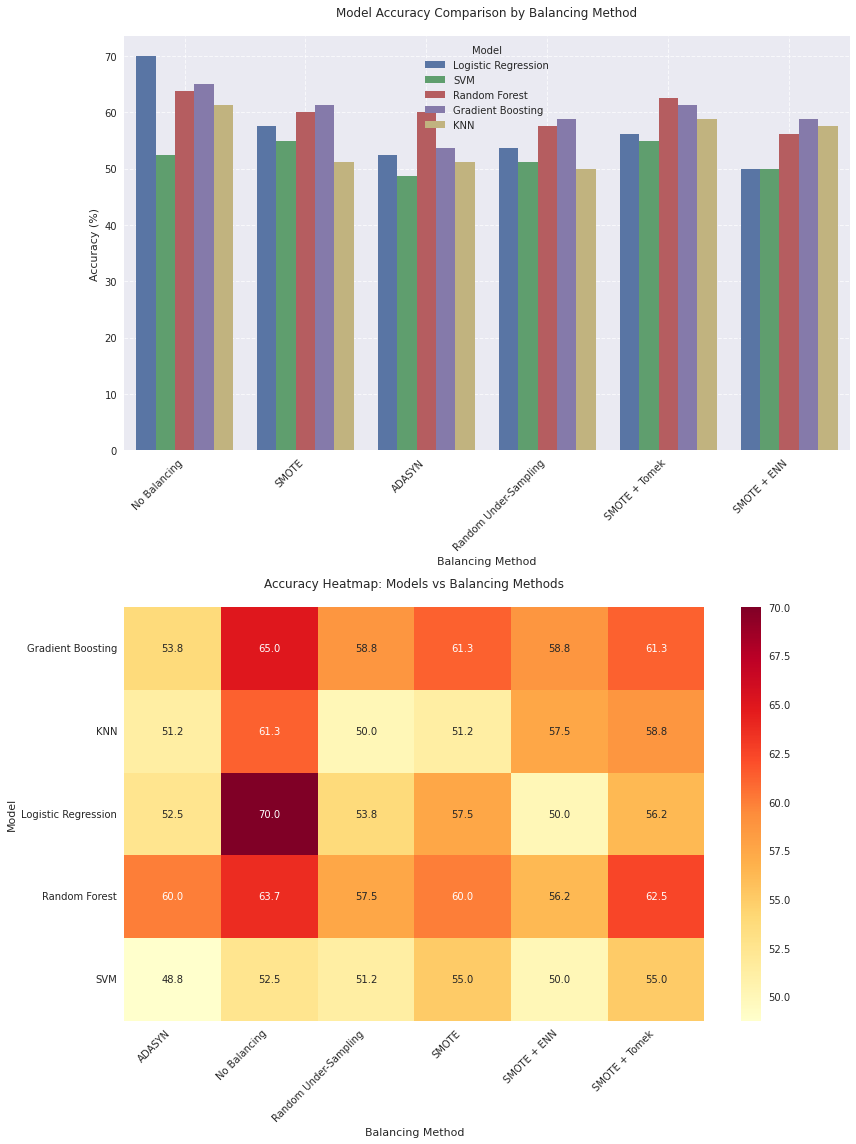


Summary Statistics:

Best performing combinations:
- Logistic Regression with No Balancing: 70.00%
- Gradient Boosting with No Balancing: 65.00%
- Random Forest with No Balancing: 63.75%

Average performance by model:
Model
Random Forest          60.000000
Gradient Boosting      59.791667
Logistic Regression    56.666667
KNN                    55.000000
SVM                    52.083333
Name: Accuracy, dtype: float64

Average performance by balancing method:
Balancing Method
No Balancing             62.50
SMOTE + Tomek            58.75
SMOTE                    57.00
SMOTE + ENN              54.50
Random Under-Sampling    54.25
ADASYN                   53.25
Name: Accuracy, dtype: float64


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
import ast

def extract_features(input_frame):
    """Extract features using the specified method"""
    extract_frame = input_frame.copy()
    
    # Initialize lists for all features
    medianrr = []
    meanrr = []
    rmssd = []
    sdrr_rmssd = []
    hr = []
    avrr = []
    sdrr = []
    skew_ = []
    kurt = []
    NNx = []
    pNNx = []
    SD1 = []
    SD2 = []
    CSI = []
    CVI = []
    modifiedCVI = []
    SD1overSD2 = []
    
    print("Extracting features...")
    # Extract features for each row
    for index, row in extract_frame.iterrows():
        try:
            # Convert string representation to list if necessary
            feature_data = ast.literal_eval(row['feature']) if isinstance(row['feature'], str) else row['feature']
            
            rmssd.append(calc_rmssd(feature_data))
            avrr.append(calc_avrr(feature_data))
            sdrr.append(calc_sdrr(feature_data))
            skew_.append(calc_skew(feature_data))
            kurt.append(calc_kurt(feature_data))
            NNx.append(calc_NNx(pd.Series(feature_data)))
            pNNx.append(calc_pNNx(pd.Series(feature_data)))
            SD1.append(calc_SD1(feature_data))
            SD2.append(calc_SD2(feature_data))
            CSI.append(calc_CSI(feature_data))
            CVI.append(calc_CVI(feature_data))
            modifiedCVI.append(calc_modifiedCVI(feature_data))
            SD1overSD2.append(calc_SD1overSD2(feature_data))
            meanrr.append(calc_meanrr(pd.Series(feature_data)))
            medianrr.append(calc_medianrr(pd.Series(feature_data)))
            hr.append(calc_hr(pd.Series(feature_data)))
            sdrrrmssd = calc_sdrr(feature_data) / calc_rmssd(feature_data)
            sdrr_rmssd.append(sdrrrmssd)
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            # Append NaN for this row
            for lst in [meanrr, medianrr, rmssd, sdrr_rmssd, hr, avrr, sdrr, skew_, 
                       kurt, NNx, pNNx, SD1, SD2, CSI, CVI, modifiedCVI, SD1overSD2]:
                lst.append(np.nan)
    
    # Add features to dataframe
    extract_frame['meanrr'] = meanrr
    extract_frame['medianrr'] = medianrr
    extract_frame['sdrr'] = sdrr
    extract_frame['rmssd'] = rmssd
    extract_frame['sdrr_rmssd'] = sdrr_rmssd
    extract_frame['hr'] = hr
    extract_frame['NNx'] = NNx
    extract_frame['pNNx'] = pNNx
    extract_frame['sd1'] = SD1
    extract_frame['sd2'] = SD2
    extract_frame['avrr'] = avrr
    extract_frame['skew'] = skew_
    extract_frame['kurt'] = kurt
    extract_frame['csi'] = CSI
    extract_frame['cvi'] = CVI
    extract_frame['modifiedcvi'] = modifiedCVI
    extract_frame['sd1_sd2_ratio'] = SD1overSD2
    
    return extract_frame

def prepare_data(extract_frame):
    """Prepare data for modeling"""
    # Select feature columns
    feature_cols = ['meanrr', 'medianrr', 'sdrr', 'rmssd', 'sdrr_rmssd', 'hr', 
                   'NNx', 'pNNx', 'sd1', 'sd2', 'avrr', 'skew', 'kurt', 
                   'csi', 'cvi', 'modifiedcvi', 'sd1_sd2_ratio']
    
    # Remove rows with NaN values
    extract_frame = extract_frame.dropna(subset=feature_cols)
    
    X = extract_frame[feature_cols]
    # Convert arousal to binary (HA=1, LA=0)
    y = (extract_frame['Arousal'] == 'HA').astype(int)
    
    return X, y

def train_and_evaluate_models(X, y, balancing_method=None):
    """Train and evaluate models with optional balancing"""
    # Split the data first to prevent data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply balancing if specified
    if balancing_method is not None:
        X_train_balanced, y_train_balanced = balancing_method.fit_resample(X_train_scaled, y_train)
    else:
        X_train_balanced, y_train_balanced = X_train_scaled, y_train
    
    # Print class distribution after balancing
    print("\nClass distribution after balancing:")
    print(pd.Series(y_train_balanced).value_counts(normalize=True))
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        model.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions and calculate accuracy
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {
            'accuracy': accuracy * 100,
            'report': classification_report(y_test, y_pred)
        }
    
    return results

def evaluate_all_balancing_methods(X, y):
    """Evaluate different balancing methods"""
    # Define balancing methods
    balancing_methods = {
        'No Balancing': None,
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'Random Under-Sampling': RandomUnderSampler(random_state=42),
        'SMOTE + Tomek': SMOTETomek(random_state=42),
        'SMOTE + ENN': SMOTEENN(random_state=42)
    }
    
    # Evaluate each balancing method
    all_results = {}
    for method_name, method in balancing_methods.items():
        print(f"\n{'-'*50}")
        print(f"Evaluating {method_name}")
        results = train_and_evaluate_models(X, y, method)
        all_results[method_name] = results
    
    return all_results
def visualize_results(all_results):
    """Create visualizations comparing model accuracies across different balancing methods"""
    # Extract accuracies into a format suitable for plotting
    data = []
    for method_name, results in all_results.items():
        for model_name, result in results.items():
            data.append({
                'Balancing Method': method_name,
                'Model': model_name,
                'Accuracy': result['accuracy']
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Set up the plot style
    plt.style.use('seaborn')
    
    # Create figure and axes with appropriate size
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    # 1. Bar plot grouped by balancing method
    sns.barplot(data=df, x='Balancing Method', y='Accuracy', hue='Model', ax=ax1)
    ax1.set_title('Model Accuracy Comparison by Balancing Method', pad=20)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_ylabel('Accuracy (%)')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Heatmap of accuracies
    pivot_df = df.pivot(index='Model', columns='Balancing Method', values='Accuracy')
    sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Accuracy Heatmap: Models vs Balancing Methods', pad=20)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nBest performing combinations:")
    # Get top 3 performing combinations
    top_3 = df.nlargest(3, 'Accuracy')
    for _, row in top_3.iterrows():
        print(f"- {row['Model']} with {row['Balancing Method']}: {row['Accuracy']:.2f}%")
    
    # Average performance by model
    print("\nAverage performance by model:")
    print(df.groupby('Model')['Accuracy'].mean().sort_values(ascending=False))
    
    # Average performance by balancing method
    print("\nAverage performance by balancing method:")
    print(df.groupby('Balancing Method')['Accuracy'].mean().sort_values(ascending=False))

def print_results(all_results):
    """Print results in a structured format"""
    print("\n========== FINAL RESULTS ==========")
    for method_name, results in all_results.items():
        print(f"\n{'-'*20} {method_name} {'-'*20}")
        for model_name, result in results.items():
            print(f"\n{model_name}:")
            print(f"Accuracy: {result['accuracy']:.2f}%")
            print("\nClassification Report:")
            print(result['report'])

  # Add visualization
    visualize_results(all_results)

def main(input_frame):
    # Extract features
    print("Starting feature extraction...")
    extract_frame = extract_features(input_frame)
    
    # Prepare data for modeling
    print("\nPreparing data for modeling...")
    X, y = prepare_data(extract_frame)
    
    print(f"\nDataset shape: {X.shape}")
    print(f"Original class distribution:")
    print(pd.Series(y).value_counts(normalize=True))
    
    # Evaluate all balancing methods
    print("\nEvaluating different balancing methods...")
    all_results = evaluate_all_balancing_methods(X, y)
    
    # Print final results
    print_results(all_results)

# Run the classification
main(train_d_frame)

# FOUR CLASS CLASSIFIER



Starting feature extraction...
Extracting features...

Preparing data for modeling...

Label mapping:
HVHA: 0
HVLA: 1
LVHA: 2
LVLA: 3

Dataset shape: (399, 17)
Original class distribution:
LVLA: 46.62%
HVLA: 21.55%
LVHA: 20.30%
HVHA: 11.53%

Evaluating different balancing methods...

--------------------------------------------------
Evaluating No Balancing

Class distribution after balancing:
LVLA: 46.39%
HVLA: 21.63%
LVHA: 20.38%
HVHA: 11.60%

Training Logistic Regression...

Training SVM...

Training Random Forest...


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Training Gradient Boosting...

Training KNN...

--------------------------------------------------
Evaluating SMOTE

Class distribution after balancing:
LVHA: 25.00%
LVLA: 25.00%
HVLA: 25.00%
HVHA: 25.00%

Training Logistic Regression...

Training SVM...

Training Random Forest...

Training Gradient Boosting...

Training KNN...

--------------------------------------------------
Evaluating Random Under-Sampling

Class distribution after balancing:
HVHA: 25.00%
HVLA: 25.00%
LVHA: 25.00%
LVLA: 25.00%

Training Logistic Regression...

Training SVM...

Training Random Forest...

Training Gradient Boosting...

Training KNN...

--------------------------------------------------
Evaluating SMOTE + Tomek

Class distribution after balancing:
LVHA: 25.63%
HVLA: 24.91%
LVLA: 24.73%
HVHA: 24.73%

Training Logistic Regression...

Training SVM...

Training Random Forest...

Training Gradient Boosting...

Training KNN...

--------------------------------------------------
Evaluating SMOTE + ENN

Cla

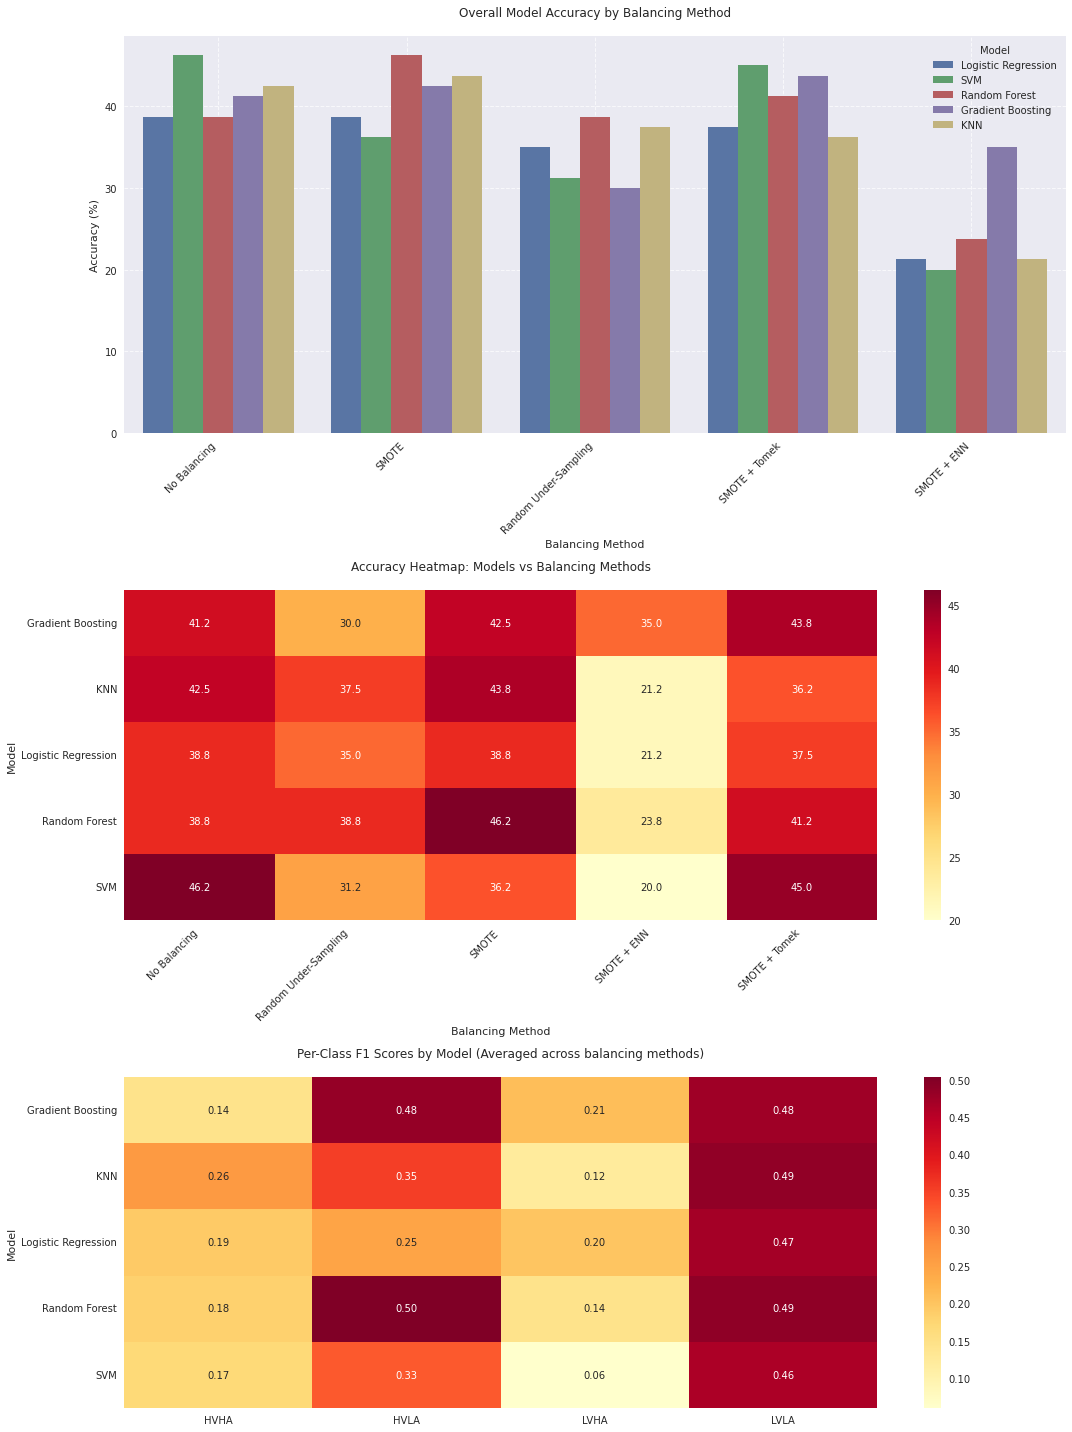


Summary Statistics:

Best performing combinations:
- SVM with No Balancing: 46.25%
- Random Forest with SMOTE: 46.25%
- SVM with SMOTE + Tomek: 45.00%

Average performance by model:
Gradient Boosting: 38.50%
Random Forest: 37.75%
KNN: 36.25%
SVM: 35.75%
Logistic Regression: 34.25%

Average performance by balancing method:
No Balancing: 41.50%
SMOTE: 41.50%
SMOTE + Tomek: 40.75%
Random Under-Sampling: 34.50%
SMOTE + ENN: 24.25%

Per-class F1-score analysis:

Logistic Regression:
  HVHA: 0.19
  HVLA: 0.25
  LVHA: 0.20
  LVLA: 0.47

SVM:
  HVHA: 0.17
  HVLA: 0.33
  LVHA: 0.06
  LVLA: 0.46

Random Forest:
  HVHA: 0.18
  HVLA: 0.50
  LVHA: 0.14
  LVLA: 0.49

Gradient Boosting:
  HVHA: 0.14
  HVLA: 0.48
  LVHA: 0.21
  LVLA: 0.48

KNN:
  HVHA: 0.26
  HVLA: 0.35
  LVHA: 0.12
  LVLA: 0.49


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
import ast

def extract_features(input_frame):
    """Extract features using the specified method"""
    extract_frame = input_frame.copy()
    
    # Initialize lists for all features
    medianrr = []
    meanrr = []
    rmssd = []
    sdrr_rmssd = []
    hr = []
    avrr = []
    sdrr = []
    skew_ = []
    kurt = []
    NNx = []
    pNNx = []
    SD1 = []
    SD2 = []
    CSI = []
    CVI = []
    modifiedCVI = []
    SD1overSD2 = []
    
    print("Extracting features...")
    # Extract features for each row
    for index, row in extract_frame.iterrows():
        try:
            # Convert string representation to list if necessary
            feature_data = ast.literal_eval(row['feature']) if isinstance(row['feature'], str) else row['feature']
            
            rmssd.append(calc_rmssd(feature_data))
            avrr.append(calc_avrr(feature_data))
            sdrr.append(calc_sdrr(feature_data))
            skew_.append(calc_skew(feature_data))
            kurt.append(calc_kurt(feature_data))
            NNx.append(calc_NNx(pd.Series(feature_data)))
            pNNx.append(calc_pNNx(pd.Series(feature_data)))
            SD1.append(calc_SD1(feature_data))
            SD2.append(calc_SD2(feature_data))
            CSI.append(calc_CSI(feature_data))
            CVI.append(calc_CVI(feature_data))
            modifiedCVI.append(calc_modifiedCVI(feature_data))
            SD1overSD2.append(calc_SD1overSD2(feature_data))
            meanrr.append(calc_meanrr(pd.Series(feature_data)))
            medianrr.append(calc_medianrr(pd.Series(feature_data)))
            hr.append(calc_hr(pd.Series(feature_data)))
            sdrrrmssd = calc_sdrr(feature_data) / calc_rmssd(feature_data)
            sdrr_rmssd.append(sdrrrmssd)
        except Exception as e:
            print(f"Error processing row {index}: {e}")
            # Append NaN for this row
            for lst in [meanrr, medianrr, rmssd, sdrr_rmssd, hr, avrr, sdrr, skew_, 
                       kurt, NNx, pNNx, SD1, SD2, CSI, CVI, modifiedCVI, SD1overSD2]:
                lst.append(np.nan)
    
    # Add features to dataframe
    extract_frame['meanrr'] = meanrr
    extract_frame['medianrr'] = medianrr
    extract_frame['sdrr'] = sdrr
    extract_frame['rmssd'] = rmssd
    extract_frame['sdrr_rmssd'] = sdrr_rmssd
    extract_frame['hr'] = hr
    extract_frame['NNx'] = NNx
    extract_frame['pNNx'] = pNNx
    extract_frame['sd1'] = SD1
    extract_frame['sd2'] = SD2
    extract_frame['avrr'] = avrr
    extract_frame['skew'] = skew_
    extract_frame['kurt'] = kurt
    extract_frame['csi'] = CSI
    extract_frame['cvi'] = CVI
    extract_frame['modifiedcvi'] = modifiedCVI
    extract_frame['sd1_sd2_ratio'] = SD1overSD2
    
    return extract_frame

def prepare_data(extract_frame):
    """Prepare data for modeling"""
    # Select feature columns
    feature_cols = ['meanrr', 'medianrr', 'sdrr', 'rmssd', 'sdrr_rmssd', 'hr', 
                   'NNx', 'pNNx', 'sd1', 'sd2', 'avrr', 'skew', 'kurt', 
                   'csi', 'cvi', 'modifiedcvi', 'sd1_sd2_ratio']
    
    # Remove rows with NaN values
    extract_frame = extract_frame.dropna(subset=feature_cols)
    
    X = extract_frame[feature_cols]
    
    # Use LabelEncoder for the 'Four label' target
    le = LabelEncoder()
    y = le.fit_transform(extract_frame['Four label'])
    
    # Store the label mapping for reference
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("\nLabel mapping:")
    for label, encoded_value in label_mapping.items():
        print(f"{label}: {encoded_value}")
    
    return X, y, le

def train_and_evaluate_models(X, y, label_encoder, balancing_method=None):
    """Train and evaluate models with optional balancing"""
    # Split the data first to prevent data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply balancing if specified
    if balancing_method is not None:
        try:
            X_train_balanced, y_train_balanced = balancing_method.fit_resample(X_train_scaled, y_train)
        except ValueError as e:
            print(f"Warning: Balancing failed with error: {e}")
            print("Proceeding with unbalanced data...")
            X_train_balanced, y_train_balanced = X_train_scaled, y_train
    else:
        X_train_balanced, y_train_balanced = X_train_scaled, y_train
    
    # Print class distribution after balancing
    print("\nClass distribution after balancing:")
    class_dist = pd.Series(y_train_balanced).value_counts(normalize=True)
    for idx, value in class_dist.items():
        label = label_encoder.inverse_transform([idx])[0]
        print(f"{label}: {value:.2%}")
    
    # Initialize models with multi-class settings
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'),
        'SVM': SVC(random_state=42, decision_function_shape='ovo'),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        model.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions and calculate accuracy
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Generate classification report with proper label names
        report = classification_report(
            y_test, 
            y_pred,
            target_names=label_encoder.classes_
        )
        
        results[name] = {
            'accuracy': accuracy * 100,
            'report': report
        }
    
    return results

def evaluate_all_balancing_methods(X, y, label_encoder):
    """Evaluate different balancing methods"""
    # Define balancing methods
    balancing_methods = {
        'No Balancing': None,
        'SMOTE': SMOTE(random_state=42),
        'Random Under-Sampling': RandomUnderSampler(random_state=42),
        'SMOTE + Tomek': SMOTETomek(random_state=42),
        'SMOTE + ENN': SMOTEENN(random_state=42)
    }
    
    # Evaluate each balancing method
    all_results = {}
    for method_name, method in balancing_methods.items():
        print(f"\n{'-'*50}")
        print(f"Evaluating {method_name}")
        results = train_and_evaluate_models(X, y, label_encoder, method)
        all_results[method_name] = results
    
    return all_results

def visualize_results(all_results, label_encoder):
    """Create visualizations comparing model accuracies across different balancing methods"""
    # Extract accuracies into a format suitable for plotting
    data = []
    for method_name, results in all_results.items():
        for model_name, result in results.items():
            # Extract per-class metrics from classification report
            report_lines = result['report'].split('\n')
            class_metrics = {}
            
            # Parse the classification report for per-class metrics
            for line in report_lines[2:-5]:  # Skip header and average lines
                if line.strip():
                    parts = line.split()
                    if len(parts) >= 5:  # Ensure line contains metrics
                        class_name = ' '.join(parts[:-4])
                        f1_score = float(parts[-2])
                        class_metrics[class_name] = f1_score
            
            # Add overall accuracy and per-class metrics
            data.append({
                'Balancing Method': method_name,
                'Model': model_name,
                'Accuracy': result['accuracy'],
                **{f'F1_{class_name}': f1_score 
                   for class_name, f1_score in class_metrics.items()}
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 20))
    gs = plt.GridSpec(3, 1, height_ratios=[1.2, 1, 1])
    
    # 1. Bar plot for overall accuracy
    ax1 = fig.add_subplot(gs[0])
    sns.barplot(data=df, x='Balancing Method', y='Accuracy', hue='Model', ax=ax1)
    ax1.set_title('Overall Model Accuracy by Balancing Method', pad=20, fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_ylabel('Accuracy (%)')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Heatmap of accuracies
    ax2 = fig.add_subplot(gs[1])
    pivot_df = df.pivot(index='Model', columns='Balancing Method', values='Accuracy')
    sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Accuracy Heatmap: Models vs Balancing Methods', pad=20, fontsize=12)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # 3. Per-class F1 scores
    ax3 = fig.add_subplot(gs[2])
    f1_columns = [col for col in df.columns if col.startswith('F1_')]
    f1_means = df.groupby('Model')[f1_columns].mean()
    
    # Rename columns to remove 'F1_' prefix
    f1_means.columns = [col.replace('F1_', '') for col in f1_means.columns]
    
    sns.heatmap(f1_means, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax3)
    ax3.set_title('Per-Class F1 Scores by Model (Averaged across balancing methods)', pad=20, fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nBest performing combinations:")
    # Get top 3 performing combinations
    top_3 = df.nlargest(3, 'Accuracy')
    for _, row in top_3.iterrows():
        print(f"- {row['Model']} with {row['Balancing Method']}: {row['Accuracy']:.2f}%")
    
    print("\nAverage performance by model:")
    model_means = df.groupby('Model')['Accuracy'].mean().sort_values(ascending=False)
    for model, acc in model_means.items():
        print(f"{model}: {acc:.2f}%")
    
    print("\nAverage performance by balancing method:")
    method_means = df.groupby('Balancing Method')['Accuracy'].mean().sort_values(ascending=False)
    for method, acc in method_means.items():
        print(f"{method}: {acc:.2f}%")
    
    # Per-class performance analysis
    print("\nPer-class F1-score analysis:")
    for model in df['Model'].unique():
        print(f"\n{model}:")
        model_data = df[df['Model'] == model]
        for col in f1_columns:
            class_name = col.replace('F1_', '')
            mean_f1 = model_data[col].mean()
            print(f"  {class_name}: {mean_f1:.2f}")


def print_results(all_results, label_encoder):
    """Print results in a structured format"""
    print("\n========== FINAL RESULTS ==========")
    for method_name, results in all_results.items():
        print(f"\n{'-'*20} {method_name} {'-'*20}")
        for model_name, result in results.items():
            print(f"\n{model_name}:")
            print(f"Accuracy: {result['accuracy']:.2f}%")
            print("\nClassification Report:")
            print(result['report'])

    # Add visualization
    visualize_results(all_results, label_encoder)

def main(input_frame):
    # Extract features
    print("Starting feature extraction...")
    extract_frame = extract_features(input_frame)
    
    # Prepare data for modeling
    print("\nPreparing data for modeling...")
    X, y, label_encoder = prepare_data(extract_frame)
    
    print(f"\nDataset shape: {X.shape}")
    print(f"Original class distribution:")
    class_dist = pd.Series(y).value_counts(normalize=True)
    for idx, value in class_dist.items():
        label = label_encoder.inverse_transform([idx])[0]
        print(f"{label}: {value:.2%}")
    
    # Evaluate all balancing methods
    print("\nEvaluating different balancing methods...")
    all_results = evaluate_all_balancing_methods(X, y, label_encoder)
    
    # Print final results
    print_results(all_results, label_encoder)

# Run the classification
main(train_d_frame)

# ORIGINAL CODE FOR DISCRETE EMOTION

In [ ]:
extract_frame = train_d_frame.copy()
print("--------")
extract_frame.head()
#hrv_data = train_d_frame.copy()

medianrr = []
meanrr = []
rmssd = []
sdrr_rmssd = []
hr = []
avrr = []
sdrr = []
skew_ = []
kurt = []
NNx = []
pNNx = []
SD1 = []
SD2 = []
CSI = []
CVI = []
modifiedCVI = []
SD1overSD2 = []
for index, row in extract_frame.iterrows():
    rmssd.append(calc_rmssd(row['feature']))
    avrr.append(calc_avrr(row['feature']))
    sdrr.append(calc_sdrr(row['feature']))
    skew_.append(calc_skew(row['feature']))
    kurt.append(calc_kurt(row['feature']))
    NNx.append(calc_NNx(pd.Series(row['feature'])))
    pNNx.append(calc_pNNx(pd.Series(row['feature'])))
    SD1.append(calc_SD1(row['feature']))
    SD2.append(calc_SD2(row['feature']))
    CSI.append(calc_CSI(row['feature']))
    CVI.append(calc_CVI(row['feature']))
    modifiedCVI.append(calc_modifiedCVI(row['feature']))
    SD1overSD2.append(calc_SD1overSD2(row['feature']))
    meanrr.append(calc_meanrr(pd.Series(row['feature'])))
    medianrr.append(calc_medianrr(pd.Series(row['feature'])))
    hr.append(calc_hr(pd.Series(row['feature'])))
    sdrrrmssd = calc_sdrr(row['feature']) / calc_rmssd(row['feature'])
    sdrr_rmssd.append(sdrrrmssd)
    

extract_frame['meanrr'] = meanrr
extract_frame['medianrr'] = medianrr
extract_frame['sdrr'] = sdrr
extract_frame['rmssd'] = rmssd
extract_frame['sdrr_rmssd'] = sdrr_rmssd
extract_frame['hr'] = hr
extract_frame['NNx'] = NNx
extract_frame['pNNx'] = pNNx
extract_frame['sd1'] = SD1
extract_frame['sd2'] = SD2
extract_frame['avrr'] = avrr
extract_frame['skew'] = skew_
extract_frame['kurt'] = kurt
extract_frame['avrr'] = avrr
extract_frame['csi'] = CSI
extract_frame['cvi'] = CVI
extract_frame['modifiedcvi'] = modifiedCVI
print("before dropping valence and arousal")
extract_frame.head()

extract_frame = extract_frame.drop(['Valence level', 'Arousal level', 'Dominance level'], axis = 1)
extract_frame2 = extract_frame.copy()
extract_frame = extract_frame.drop(['feature', 'Target Emotion'], axis = 1)
extract_frame = extract_frame.drop(['Valence', 'Arousal'], axis = 1)
extract_frame = extract_frame.drop(['avrr', 'csi', 'cvi', 'modifiedcvi'], axis = 1)
extract_frame.head()

In [ ]:
from sklearn import preprocessing
import seaborn as sns

In [ ]:
#extract_frame = extract_frame2.drop(['feature'], axis = 1)
#extract_frame = extract_frame2.drop(['Target Emotion'], axis = 1)
le = preprocessing.LabelEncoder()
le.fit(extract_frame['emotion'])
extract_frame['emotion'] = le.transform(extract_frame['emotion'])


In [ ]:
plt.figure(figsize=(12,10))
corr = extract_frame.corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.show()

In [ ]:
def feature_selection(correlation, threshold):
    selected_features = []
    for i in range(corr.shape[0]):
      if corr.iloc[i,0] > threshold:
        selected_features.append(extract_frame.iloc[:,i])
    return pd.DataFrame(selected_features).T

In [ ]:
#extract_frame.head()

In [ ]:
CORRELATION_THRESHOLD = 0.1
extract_frame = feature_selection(extract_frame, CORRELATION_THRESHOLD)
x = extract_frame.drop(['emotion'],axis=1)
y = extract_frame['emotion']
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

extract_frame.head()

In [ ]:
extract_frame["emotion"].tail()

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score, f1_score, cohen_kappa_score, precision_score, roc_auc_score

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=12)
# dt_model = dt_model.fit(train_x, train_y)
# dt_pred_y = dt_model.predict(test_x)

In [ ]:
# Train the model
dt_model.fit(train_x, train_y)


In [ ]:
# Make predictions
train_pred_y = dt_model.predict(train_x)
val_pred_y = dt_model.predict(test_x)
test_pred_y = val_pred_y  # Since we only have test data

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted')  # Use weighted average for multi-class
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted')  # Precision for multi-class
try:
    auc = roc_auc_score(test_y, dt_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
dt_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
dt_report_df = pd.DataFrame(dt_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(dt_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('Decision Tree Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)

# Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

In [ ]:
# Train the model
rf_model.fit(train_x, train_y)

In [ ]:

# Make predictions
train_pred_y = rf_model.predict(train_x)
val_pred_y = rf_model.predict(test_x)
test_pred_y = val_pred_y  # Since we only have test data

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted')  # Use weighted average for multi-class
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted')  # Precision for multi-class
try:
    auc = roc_auc_score(test_y, rf_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
rf_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
rf_report_df = pd.DataFrame(rf_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(rf_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('Random Forest Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)

# SVM

In [ ]:
from sklearn.svm import SVC

# Initialize the Support Vector Machine Classifier
svm_model = SVC(probability=True, kernel='rbf', random_state=0)

# Train the model
svm_model.fit(train_x, train_y)

# Make predictions
train_pred_y = svm_model.predict(train_x)
val_pred_y = svm_model.predict(test_x)
test_pred_y = val_pred_y

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted', zero_division=0)  # Use weighted average for multi-class
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted', zero_division=0)  # Precision for multi-class
try:
    auc = roc_auc_score(test_y, svm_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
svm_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
svm_report_df = pd.DataFrame(svm_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(svm_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('SVM Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)


# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost Classifier
ada_model = AdaBoostClassifier(n_estimators=70, random_state=0)

# Train the model
ada_model.fit(train_x, train_y)

# Make predictions
train_pred_y = ada_model.predict(train_x)
val_pred_y = ada_model.predict(test_x)
test_pred_y = val_pred_y

# Accuracy on train, validation (test), and overall
train_accuracy = accuracy_score(train_y, train_pred_y)
val_accuracy = accuracy_score(test_y, val_pred_y)

# F1-score, Cohen's Kappa, Precision, and AUC
f1 = f1_score(test_y, test_pred_y, average='weighted', zero_division=0)
kappa = cohen_kappa_score(test_y, test_pred_y)
precision = precision_score(test_y, test_pred_y, average='weighted', zero_division=0)
try:
    auc = roc_auc_score(test_y, ada_model.predict_proba(test_x), multi_class='ovr', average='weighted')
except:
    auc = None  # AUC may not be possible for certain types of classifiers or data

# Generate classification report
ada_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# Convert classification report into DataFrame for plotting
ada_report_df = pd.DataFrame(ada_report).transpose()

# Plot the heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(ada_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# Set the title and labels
plt.title('AdaBoost Classifier - Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Print all metrics
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
print("F1 Score:", f1)
print("Cohen Kappa Score:", kappa)
print("Precision:", precision)
print("AUC:", auc)


# KNN

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# # Initialize the KNN Classifier
# knn_model = KNeighborsClassifier(n_neighbors=5)

# # Train the model
# knn_model.fit(train_x, train_y)

# # Make predictions
# train_pred_y = knn_model.predict(train_x)
# val_pred_y = knn_model.predict(test_x)
# test_pred_y = val_pred_y

# # Accuracy on train, validation (test), and overall
# train_accuracy = accuracy_score(train_y, train_pred_y)
# val_accuracy = accuracy_score(test_y, val_pred_y)

# # F1-score, Cohen's Kappa, Precision, and AUC
# f1 = f1_score(test_y, test_pred_y, average='weighted', zero_division=0)
# kappa = cohen_kappa_score(test_y, test_pred_y)
# precision = precision_score(test_y, test_pred_y, average='weighted', zero_division=0)
# try:
#     auc = roc_auc_score(test_y, knn_model.predict_proba(test_x), multi_class='ovr', average='weighted')
# except:
#     auc = None

# # Generate classification report
# knn_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# # Convert classification report into DataFrame for plotting
# knn_report_df = pd.DataFrame(knn_report).transpose()

# # Plot the heatmap of the classification report
# plt.figure(figsize=(8, 6))
# sns.heatmap(knn_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# # Set the title and labels
# plt.title('KNN Classifier - Classification Report')
# plt.ylabel('Metrics')
# plt.xlabel('Classes')
# plt.show()

# # Print all metrics
# print("Train Accuracy:", train_accuracy)
# print("Validation Accuracy:", val_accuracy)
# print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
# print("F1 Score:", f1)
# print("Cohen Kappa Score:", kappa)
# print("Precision:", precision)
# print("AUC:", auc)


# XGBoost

In [ ]:
# import xgboost as xgb

# # Initialize the XGBoost Classifier
# xgb_model = xgb.XGBClassifier(n_estimators=10, random_state=0)

# # Train the model
# xgb_model.fit(train_x, train_y)

# # Make predictions
# train_pred_y = xgb_model.predict(train_x)
# val_pred_y = xgb_model.predict(test_x)
# test_pred_y = val_pred_y

# # Accuracy on train, validation (test), and overall
# train_accuracy = accuracy_score(train_y, train_pred_y)
# val_accuracy = accuracy_score(test_y, val_pred_y)

# # F1-score, Cohen's Kappa, Precision, and AUC
# f1 = f1_score(test_y, test_pred_y, average='weighted', zero_division=0)
# kappa = cohen_kappa_score(test_y, test_pred_y)
# precision = precision_score(test_y, test_pred_y, average='weighted', zero_division=0)
# try:
#     auc = roc_auc_score(test_y, xgb_model.predict_proba(test_x), multi_class='ovr', average='weighted')
# except:
#     auc = None

# # Generate classification report
# xgb_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# # Convert classification report into DataFrame for plotting
# xgb_report_df = pd.DataFrame(xgb_report).transpose()

# # Plot the heatmap of the classification report
# plt.figure(figsize=(8, 6))
# sns.heatmap(xgb_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# # Set the title and labels
# plt.title('XGBoost Classifier - Classification Report')
# plt.ylabel('Metrics')
# plt.xlabel('Classes')
# plt.show()

# # Print all metrics
# print("Train Accuracy:", train_accuracy)
# print("Validation Accuracy:", val_accuracy)
# print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
# print("F1 Score:", f1)
# print("Cohen Kappa Score:", kappa)
# print("Precision:", precision)
# print("AUC:", auc)


# Bagging

In [ ]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, precision_score, roc_auc_score, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Initialize the Bagging Classifier with a base classifier (DecisionTree in this case)
# bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
#                                   n_estimators=30,  # Number of base models
#                                   random_state=0)

# # Train the model
# bagging_model.fit(train_x, train_y)

# # Make predictions
# train_pred_y = bagging_model.predict(train_x)
# val_pred_y = bagging_model.predict(test_x)
# test_pred_y = val_pred_y  # Since we only have test data

# # Accuracy on train, validation (test), and overall
# train_accuracy = accuracy_score(train_y, train_pred_y)
# val_accuracy = accuracy_score(test_y, val_pred_y)

# # F1-score, Cohen's Kappa, Precision, and AUC
# f1 = f1_score(test_y, test_pred_y, average='weighted')  # Use weighted average for multi-class
# kappa = cohen_kappa_score(test_y, test_pred_y)
# precision = precision_score(test_y, test_pred_y, average='weighted')  # Precision for multi-class
# try:
#     auc = roc_auc_score(test_y, bagging_model.predict_proba(test_x), multi_class='ovr', average='weighted')
# except:
#     auc = None  # AUC may not be possible for certain types of classifiers or data

# # Generate classification report
# bagging_report = classification_report(test_y, test_pred_y, output_dict=True, zero_division=0)

# # Convert classification report into DataFrame for plotting
# bagging_report_df = pd.DataFrame(bagging_report).transpose()

# # Plot the heatmap of the classification report
# plt.figure(figsize=(8, 6))
# sns.heatmap(bagging_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)

# # Set the title and labels
# plt.title('Bagging Classifier - Classification Report')
# plt.ylabel('Metrics')
# plt.xlabel('Classes')
# plt.show()

# # Print all metrics
# print("Train Accuracy:", train_accuracy)
# print("Validation Accuracy:", val_accuracy)
# print("Test Accuracy:", accuracy_score(test_y, test_pred_y))
# print("F1 Score:", f1)
# print("Cohen Kappa Score:", kappa)
# print("Precision:", precision)
# print("AUC:", auc)


# ANN

In [ ]:
train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
                                        'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
                                       ], axis = 1)
train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
#train_d_frame.head()

In [ ]:
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.utils import to_categorical
# import seaborn as sns

# # Prepare features and labels
# x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
# y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# # Standardize features
# sc = StandardScaler()
# x = sc.fit_transform(x)

# # Encode labels
# labelencoder = LabelEncoder()
# y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
# y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# # Split into train, validation, and test sets (80% train, 10% validation, 10% test)
# x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
# x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)


In [ ]:
# # Initialize the ANN model
# ann_model = Sequential()

# # Input layer + First hidden layer
# ann_model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
# ann_model.add(Dropout(0.5))  # Dropout for regularization

# # # Second hidden layer
# # ann_model.add(Dense(32, activation='relu'))
# # ann_model.add(Dropout(0.3))

# # Output layer
# ann_model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of classes = shape[1] of y_train

# # Compile the model
# ann_model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# # Train the model
# history = ann_model.fit(x_train, y_train, 
#                         epochs=150, 
#                         batch_size=32, 
#                         validation_data=(x_val, y_val), 
#                         verbose=1)

In [ ]:
# # Evaluate the model on training, validation, and test sets
# train_accuracy = ann_model.evaluate(x_train, y_train, verbose=0)[1]
# val_accuracy = ann_model.evaluate(x_val, y_val, verbose=0)[1]
# test_accuracy = ann_model.evaluate(x_test, y_test, verbose=0)[1]

# # Predictions
# test_pred_prob = ann_model.predict(x_test)
# test_pred_y = test_pred_prob.argmax(axis=1)
# y_test_actual = y_test.argmax(axis=1)

# # F1-score, Cohen's Kappa, Precision, and AUC
# f1 = f1_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
# kappa = cohen_kappa_score(y_test_actual, test_pred_y)
# precision = precision_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
# try:
#     auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='weighted')
# except:
#     auc = None

# # Classification Report
# ann_report = classification_report(y_test_actual, test_pred_y, output_dict=True, zero_division=0)

# # Convert classification report into DataFrame for plotting
# ann_report_df = pd.DataFrame(ann_report).transpose()

# # Plot classification report as a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(ann_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)
# plt.title('ANN - Classification Report')
# plt.ylabel('Metrics')
# plt.xlabel('Classes')
# plt.show()

# # Print all metrics
# print("Train Accuracy:", train_accuracy)
# print("Validation Accuracy:", val_accuracy)
# print("Test Accuracy:", test_accuracy)
# print("F1 Score:", f1)
# print("Cohen Kappa Score:", kappa)
# print("Precision:", precision)
# print("AUC:", auc)

# # Plot training vs validation accuracy and loss
# plt.figure(figsize=(12, 5))

# # # Accuracy plot
# # plt.subplot(1, 2, 1)
# # plt.plot(history.history['accuracy'], label='Train Accuracy')
# # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# # plt.title('Accuracy vs. Epochs')
# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.legend()

# # Loss plot
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


# LSTM

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from tensorflow.keras.utils import to_categorical
# from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, cohen_kappa_score, roc_auc_score
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Prepare features and labels
# x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
# y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# # Standardize features
# sc = StandardScaler()
# x = sc.fit_transform(x)

# # Reshape for LSTM input (samples, timesteps, features)
# x = x.reshape((x.shape[0], 1, x.shape[1]))  # Add a timesteps dimension (e.g., timesteps=1)

# # Encode labels
# labelencoder = LabelEncoder()
# y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
# y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# # Split into train, validation, and test sets (80% train, 10% validation, 10% test)
# x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
# x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

# # Initialize the LSTM model
# lstm_model = Sequential()

# # Add LSTM layer
# lstm_model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu', return_sequences=False))
# lstm_model.add(Dropout(0.2))  # Dropout for regularization

# # Add output layer
# lstm_model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of classes = shape[1] of y_train

# # Compile the model
# lstm_model.compile(optimizer='adam',
#                    loss='categorical_crossentropy',
#                    metrics=['accuracy'])

# # Train the model
# history = lstm_model.fit(x_train, y_train,
#                          epochs=50,
#                          batch_size=32,
#                          validation_data=(x_val, y_val),
#                          verbose=1)


In [ ]:
# # Evaluate the model on training, validation, and test sets
# train_accuracy = lstm_model.evaluate(x_train, y_train, verbose=0)[1]
# val_accuracy = lstm_model.evaluate(x_val, y_val, verbose=0)[1]
# test_accuracy = lstm_model.evaluate(x_test, y_test, verbose=0)[1]

# # Predictions
# test_pred_prob = lstm_model.predict(x_test)
# test_pred_y = test_pred_prob.argmax(axis=1)
# y_test_actual = y_test.argmax(axis=1)

# # F1-score, Cohen's Kappa, Precision, and AUC
# f1 = f1_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
# kappa = cohen_kappa_score(y_test_actual, test_pred_y)
# precision = precision_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
# try:
#     auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='weighted')
# except:
#     auc = None

# # Classification Report
# lstm_report = classification_report(y_test_actual, test_pred_y, output_dict=True, zero_division=0)

# # Convert classification report into DataFrame for plotting
# lstm_report_df = pd.DataFrame(lstm_report).transpose()

# # # Plot classification report as a heatmap
# # plt.figure(figsize=(8, 6))
# # sns.heatmap(lstm_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)
# # plt.title('LSTM - Classification Report')
# # plt.ylabel('Metrics')
# # plt.xlabel('Classes')
# # plt.show()

# # Print all metrics
# print("Train Accuracy:", train_accuracy)
# print("Validation Accuracy:", val_accuracy)
# print("Test Accuracy:", test_accuracy)
# print("F1 Score:", f1)
# print("Cohen Kappa Score:", kappa)
# print("Precision:", precision)
# print("AUC:", auc)

# # Plot training vs validation accuracy and loss
# plt.figure(figsize=(12, 5))

# # # Accuracy plot
# # plt.subplot(1, 2, 1)
# # plt.plot(history.history['accuracy'], label='Train Accuracy')
# # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# # plt.title('Accuracy vs. Epochs')
# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.legend()

# # Loss plot
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


# Bi-LSTM

In [ ]:
# from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout


# # Prepare features and labels
# x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
# y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# # Standardize features
# sc = StandardScaler()
# x = sc.fit_transform(x)

# # Reshape for BI-LSTM input (samples, timesteps, features)
# x = x.reshape((x.shape[0], 1, x.shape[1]))  # Add a timesteps dimension (e.g., timesteps=1)

# # Encode labels
# labelencoder = LabelEncoder()
# y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
# y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# # Split into train, validation, and test sets (80% train, 10% validation, 10% test)
# x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
# x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

# # Initialize the BI-LSTM model
# bi_lstm_model = Sequential()

# # Add Bidirectional LSTM layer
# bi_lstm_model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False), input_shape=(x_train.shape[1], x_train.shape[2])))
# # bi_lstm_model.add(Dropout(0.2))  # Dropout for regularization

# # Add output layer
# bi_lstm_model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of classes = shape[1] of y_train

# # Compile the model
# bi_lstm_model.compile(optimizer='adam',
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])

# # Train the model
# history = bi_lstm_model.fit(x_train, y_train,
#                             epochs=50,
#                             batch_size=32,
#                             validation_data=(x_val, y_val),
#                             verbose=1)


In [ ]:
# # Evaluate the model on training, validation, and test sets
# train_accuracy = bi_lstm_model.evaluate(x_train, y_train, verbose=0)[1]
# val_accuracy = bi_lstm_model.evaluate(x_val, y_val, verbose=0)[1]
# test_accuracy = bi_lstm_model.evaluate(x_test, y_test, verbose=0)[1]

# # Predictions
# test_pred_prob = bi_lstm_model.predict(x_test)
# test_pred_y = test_pred_prob.argmax(axis=1)
# y_test_actual = y_test.argmax(axis=1)

# # F1-score, Cohen's Kappa, Precision, and AUC
# f1 = f1_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
# kappa = cohen_kappa_score(y_test_actual, test_pred_y)
# precision = precision_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
# try:
#     auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='weighted')
# except:
#     auc = None

# # Classification Report
# bi_lstm_report = classification_report(y_test_actual, test_pred_y, output_dict=True, zero_division=0)

# # Convert classification report into DataFrame for plotting
# bi_lstm_report_df = pd.DataFrame(bi_lstm_report).transpose()

# # # Plot classification report as a heatmap
# # plt.figure(figsize=(8, 6))
# # sns.heatmap(bi_lstm_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)
# # plt.title('BI-LSTM - Classification Report')
# # plt.ylabel('Metrics')
# # plt.xlabel('Classes')
# # plt.show()

# # Print all metrics
# print("Train Accuracy:", train_accuracy)
# print("Validation Accuracy:", val_accuracy)
# print("Test Accuracy:", test_accuracy)
# print("F1 Score:", f1)
# print("Cohen Kappa Score:", kappa)
# print("Precision:", precision)
# print("AUC:", auc)

# # Plot training vs validation accuracy and loss
# plt.figure(figsize=(12, 5))

# # # Accuracy plot
# # plt.subplot(1, 2, 1)
# # plt.plot(history.history['accuracy'], label='Train Accuracy')
# # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# # plt.title('Accuracy vs. Epochs')
# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.legend()

# # Loss plot
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# # Prepare features and labels
# x = np.array(train_d_frame['feature'].tolist())  # Ensure 'feature' is a list of lists or arrays
# y = np.array(train_d_frame['emotion'].tolist())  # Ensure 'emotion' contains valid labels

# # Standardize features
# sc = StandardScaler()
# x = sc.fit_transform(x)

# # Reshape for 1D CNN input (samples, timesteps, features)
# x = x.reshape((x.shape[0], x.shape[1], 1))  # Add a single feature channel dimension

# # Encode labels
# labelencoder = LabelEncoder()
# y_encoded = labelencoder.fit_transform(y)  # Transform labels to integer values
# y = to_categorical(y_encoded)  # Convert to one-hot encoded format

# # Split into train, validation, and test sets (80% train, 10% validation, 10% test)
# x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=0)
# x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

# # Initialize the 1D CNN model
# cnn_model = Sequential()

# # Add convolutional layers
# cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
# cnn_model.add(MaxPooling1D(pool_size=2))  # Max pooling for down-sampling
# cnn_model.add(Dropout(0.3))  # Dropout for regularization

# # Add another convolutional layer
# cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Dropout(0.3))

# # Flatten the feature map
# cnn_model.add(Flatten())

# # Add a dense layer
# cnn_model.add(Dense(64, activation='relu'))
# cnn_model.add(Dropout(0.5))

# # Add the output layer
# cnn_model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of classes = shape[1] of y_train

# # Compile the model
# cnn_model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# # Train the model
# history = cnn_model.fit(x_train, y_train,
#                         epochs=50,
#                         batch_size=32,
#                         validation_data=(x_val, y_val),
#                         verbose=1)



In [ ]:

# # Evaluate the model on training, validation, and test sets
# train_accuracy = cnn_model.evaluate(x_train, y_train, verbose=0)[1]
# val_accuracy = cnn_model.evaluate(x_val, y_val, verbose=0)[1]
# test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)[1]

# # Predictions
# test_pred_prob = cnn_model.predict(x_test)
# test_pred_y = test_pred_prob.argmax(axis=1)
# y_test_actual = y_test.argmax(axis=1)

# # F1-score, Cohen's Kappa, Precision, and AUC
# f1 = f1_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
# kappa = cohen_kappa_score(y_test_actual, test_pred_y)
# precision = precision_score(y_test_actual, test_pred_y, average='weighted', zero_division=0)
# try:
#     auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='weighted')
# except:
#     auc = None

# # Classification Report
# cnn_report = classification_report(y_test_actual, test_pred_y, output_dict=True, zero_division=0)

# # Convert classification report into DataFrame for plotting
# cnn_report_df = pd.DataFrame(cnn_report).transpose()

# # # Plot classification report as a heatmap
# # plt.figure(figsize=(8, 6))
# # sns.heatmap(cnn_report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt='.2f', cbar=False)
# # plt.title('1D CNN - Classification Report')
# # plt.ylabel('Metrics')
# # plt.xlabel('Classes')
# # plt.show()

# # Print all metrics
# print("Train Accuracy:", train_accuracy)
# print("Validation Accuracy:", val_accuracy)
# print("Test Accuracy:", test_accuracy)
# print("F1 Score:", f1)
# print("Cohen Kappa Score:", kappa)
# print("Precision:", precision)
# print("AUC:", auc)

# # Plot training vs validation accuracy and loss
# plt.figure(figsize=(12, 5))

# # # Accuracy plot
# # plt.subplot(1, 2, 1)
# # plt.plot(history.history['accuracy'], label='Train Accuracy')
# # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# # plt.title('Accuracy vs. Epochs')
# # plt.xlabel('Epochs')
# # plt.ylabel('Accuracy')
# # plt.legend()

# # Loss plot
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()
